# House Price Prediction

## Exploratory Data Analysis

First importing the data, relevant packages and conducting EDA, in preparation for analysis.

In [1]:
import pandas as pd
import forecast
from forecast import histogram, qq_plot
from statlearning import rmse_jack
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import neighbors
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
house_train = pd.read_csv("train.csv")
house_train.head()

Train_ID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0         1           60        RL          88.0     12128   Pave   NaN   
1         2          120        RL          48.0      6240   Pave   NaN   
2         3           50        RL         120.0     17360   Pave   NaN   
3         4           20        RL          73.0      8688   Pave   NaN   
4         5           80        RL          88.0     15312   Pave   NaN   

  Lot Shape Land Contour Utilities  ... Pool Area Pool QC  Fence Misc Feature  \
0       IR1          Bnk    AllPub  ...         0     NaN  MnPrv          NaN   
1       Reg          Lvl    AllPub  ...         0     NaN    NaN          NaN   
2       Reg          Lvl    AllPub  ...         0     NaN    NaN          NaN   
3       Reg          Lvl    AllPub  ...         0     NaN    NaN          NaN   
4       Reg          Lvl    AllPub  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  SalePrice  
0        0      11    2006        WD          Abnorml     209000  
1        0      12    2009        WD           Normal     254000  
2        0       1    2010        WD           Normal     172500  
3        0       4    2006        WD           Normal     232000  
4        0       3    2009        COD          Normal     148000  

[5 rows x 81 columns]

In [4]:
house_test = pd.read_csv("test.csv")
house_test.head()

Test_ID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0        1           80        RL         120.0     19296   Pave   NaN   
1        2           20        RL          80.0     10928   Pave   NaN   
2        3          160        RL          24.0      2280   Pave   NaN   
3        4           20        RL          60.0      8428   Pave   NaN   
4        5           50        RM          50.0      9140   Pave   NaN   

  Lot Shape Land Contour Utilities  ... Screen Porch Pool Area Pool QC  Fence  \
0       Reg          Lvl    AllPub  ...            0         0     NaN   GdWo   
1       Reg          Lvl    AllPub  ...            0         0     NaN    NaN   
2       Reg          Lvl    AllPub  ...            0         0     NaN    NaN   
3       IR2          Lvl    AllPub  ...            0         0     NaN    NaN   
4       Reg          HLS    AllPub  ...          200         0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  Sale Condition  
0          NaN        0       5     2009        WD           Normal  
1          NaN        0       8     2009        WD           Normal  
2          NaN        0       7     2009        WD           Normal  
3          NaN        0       7     2007        WD           Normal  
4          NaN        0       4     2010        COD          Normal  

[5 rows x 80 columns]

In [5]:
old_obs_n = house_train.shape[0]
print(f'Train dataset has {house_train.shape[0]} rows and {house_train.shape[1]} columns.')
print(f'Test dataset has {house_test.shape[0]} rows and {house_test.shape[1]} columns.')

Train dataset has 1570 rows and 81 columns.
Test dataset has 1210 rows and 80 columns.


The datasets are moderately large and have a large number of features.

In [6]:
print(f'There are {house_train.isnull().any().sum()} columns in train dataset with missing values.')

There are 24 columns in train dataset with missing values.


There are a number of columns with missing values. These need to be investigated before we engage in feature engineering.

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(house_test.dtypes)

Test_ID              int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1         int64
BsmtFin Type 2      object
BsmtFin SF 2         int64
B

There are a number of qualitative variables that may require dummy variables to be created for these. This will be applied after an individual inspection of each of the variables in feature engineering.

Before identifying the most ideal features, we will first delve into each of the variables to ensure that the data having been inputted is logically consistent i.e. values correspond logically with the variable.

In [8]:
col_names = list(house_train.columns)

# for i in col_names:
#     plt.hist(house_train[i].dropna(), bins=50);
#     if i == "Year Remod/Add":
#         i = "Year Remod-Add"
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     else:
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     plt.show()

Nothing too unusual is noticeable in the data, however there is some skewness to a number of features and should be considered in feature engineering.

Now, using an IQR approach to identifying outliers these should be noted.

In [9]:
# to only consider numerical features in outlier detection
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = house_train.select_dtypes(include=numerics).copy()

To ensure no categorical variables were selected the data types and descriptions of the data were compared with those selected in the numerics dataframe.

In [10]:
newdf.columns

Index(['Train_ID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

Since "MS SubClass" and "Overall Cond" were categorical by nature, the incorrect selection of these variables as numerical meant they were dropped.

In [11]:
del newdf['Train_ID']
del newdf["MS SubClass"]
del newdf['Overall Cond']

In [12]:
Q1 = newdf.quantile(0.25)
Q3 = newdf.quantile(0.75)
IQR = Q3 - Q1

In [13]:
house_train_out = newdf[((newdf < (Q1 - 1.5 * IQR)) |(newdf > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

In [14]:
print(f'The dataset has {house_train_out.shape[0]} outliers.')

The dataset has 910 outliers.


Since, there were 966 observations that contain at least one outlier under one of its features, this representing a significant proportion of the train dataset it was considered that these would not be ignored in training.

## Feature Engineering

First we will examine for the most relevant numerical variables in the dataset. Later, the categorical features will be converted to dummies so that they can be usable for predictive modelling.

Minusing the year it was sold in to the year it was constructed the new variable 'Age' was created. Also, minusing the last year it was remodelled or had additions made to the house to the year it was sold was added as the 'Last remod/add' feature. The same was also done for "Garage Yr Blt".

In [15]:
house_train['Age'] = house_train['Yr Sold'] - house_train['Year Built']
house_train['Last remod/add'] = house_train['Yr Sold'] - house_train['Year Remod/Add']
house_train['Garage Age'] = house_train['Yr Sold'] - house_train["Garage Yr Blt"]

house_test['Age'] = house_test['Yr Sold'] - house_test['Year Built']
house_test['Last remod/add'] = house_test['Yr Sold'] - house_test['Year Remod/Add']
house_test['Garage Age'] = house_test['Yr Sold'] - house_test['Garage Yr Blt']

In [16]:
num_house_train = house_train[['MS SubClass','Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Garage Age','Last remod/add','SalePrice']].copy()

Let's create a series of scatter plots of the narrowed numerical features against 'SalePrice' to understand what relationships may be present between these variables.

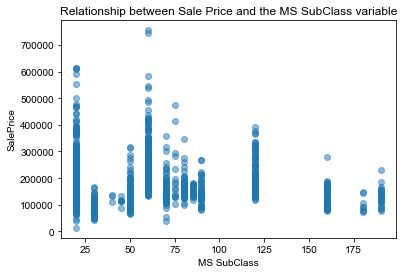

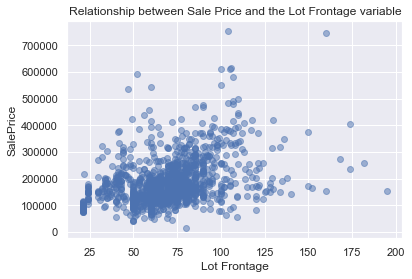

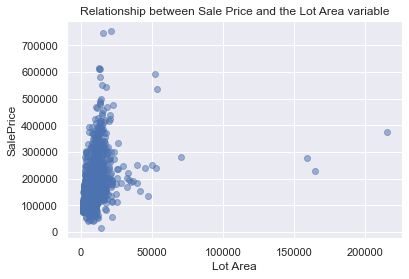

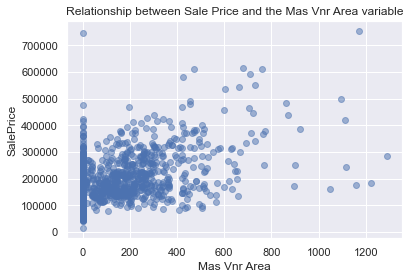

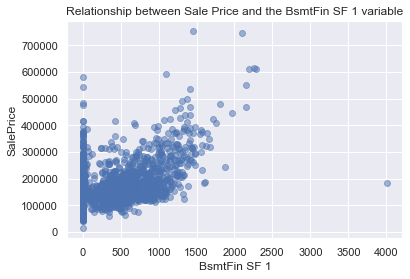

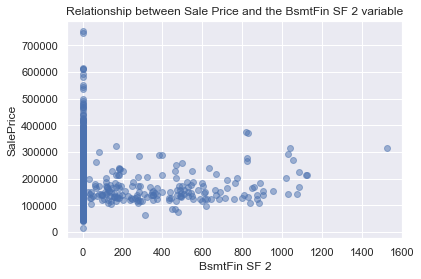

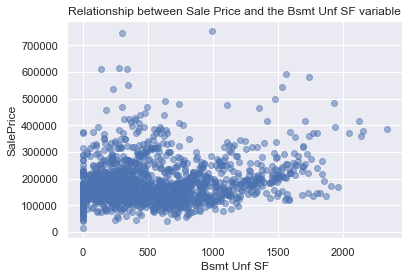

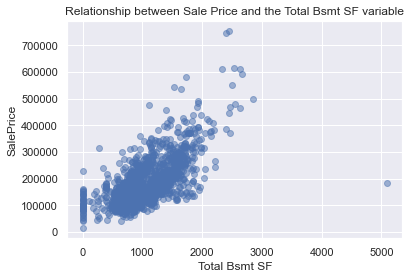

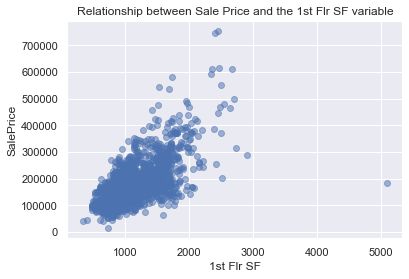

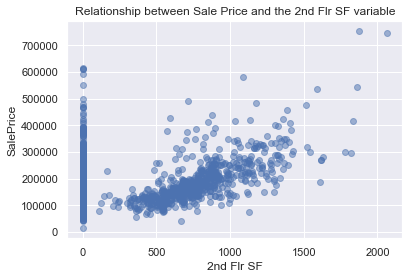

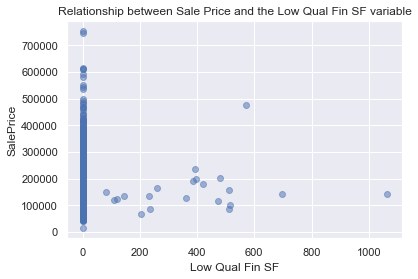

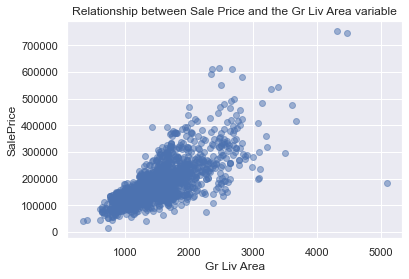

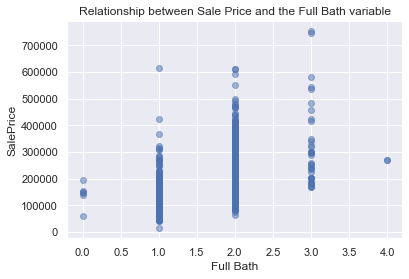

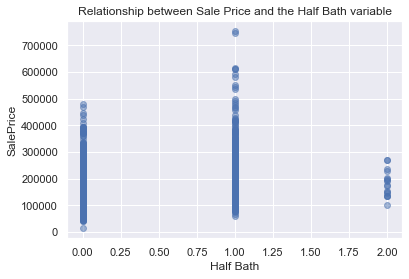

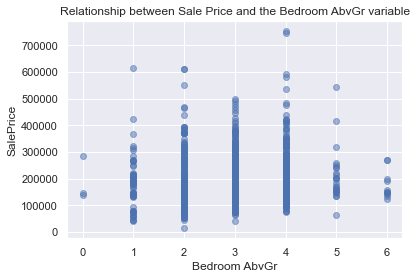

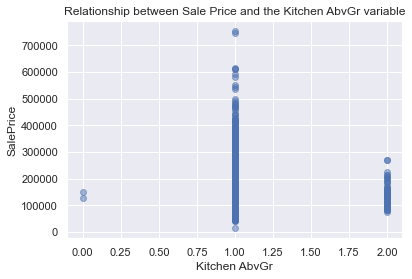

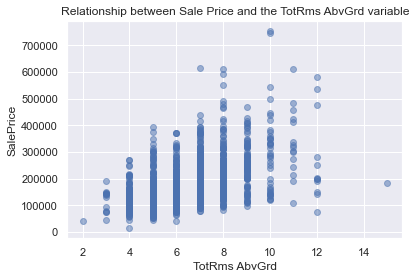

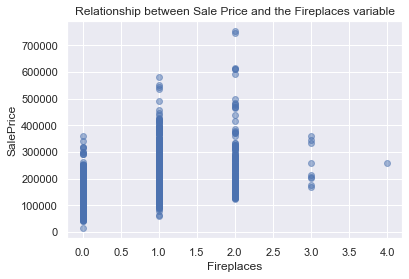

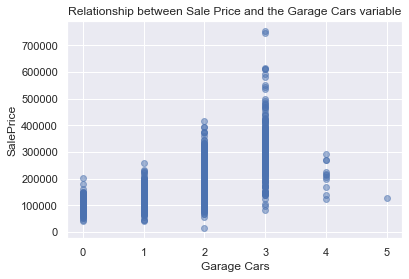

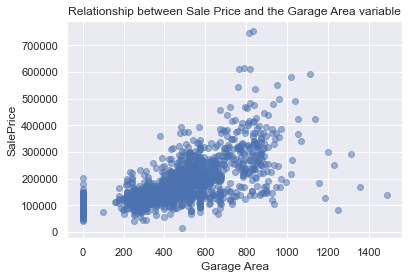

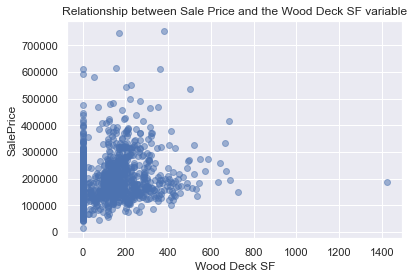

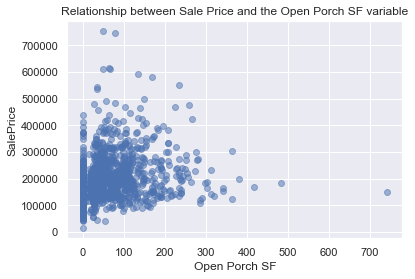

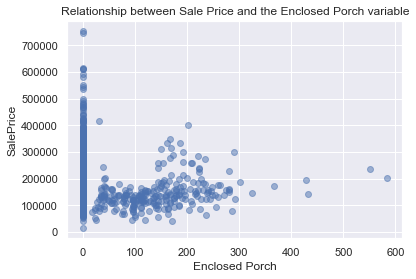

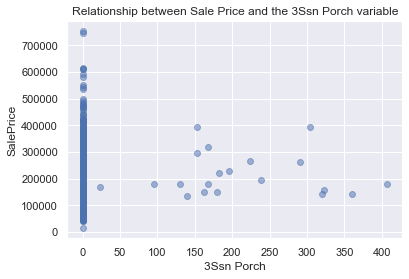

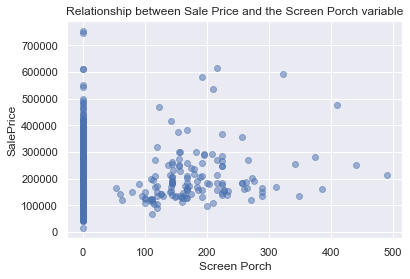

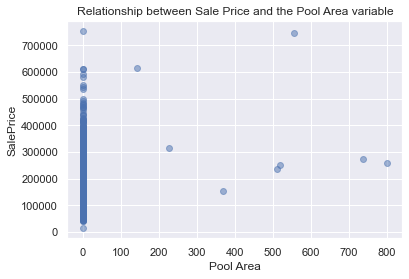

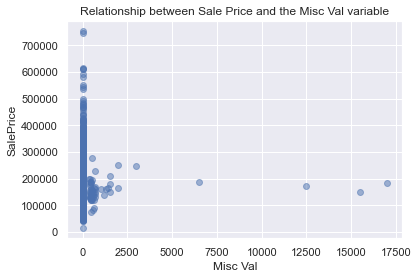

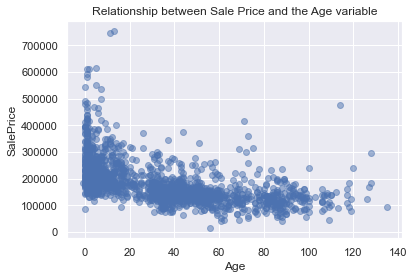

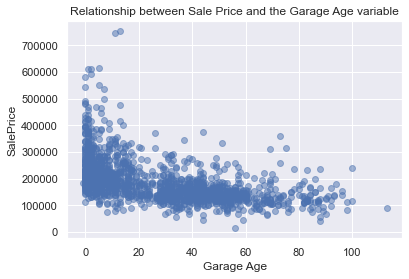

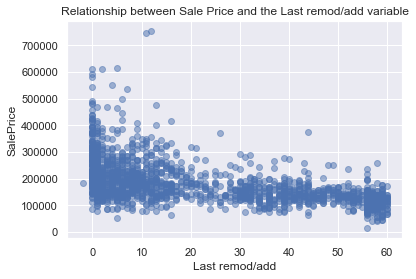

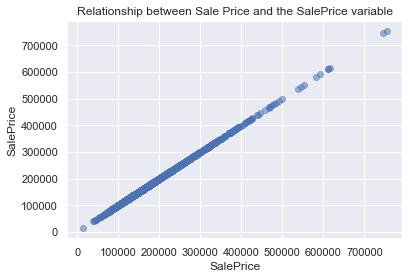

In [17]:
col_names = list(num_house_train.columns)

for i in col_names:
    plt.scatter(num_house_train[i], num_house_train['SalePrice'], alpha = 0.5);
    plt.title(f'Relationship between Sale Price and the {i} variable');
    sns.set(font_scale=1)
    plt.xlabel(i)
    plt.ylabel("SalePrice")
    if i == "Last remod/add":
        plt.savefig(f'Relationship between Sale Price and the Last remod-add variable',bbox_inches='tight')
    else:
        plt.savefig(f'Relationship between Sale Price and the {i} variable',bbox_inches='tight')
    plt.show()

Viewing the scatter plots the best variables to consider are "Gr Liv Area", "Garage Area", "Age", "Garage Age", "Last remod/add", "Total Bsmt SF", "1st Flr SF", '2nd Flr SF', “BsmtFin SF 1”, “Full Bath”, “TotRms AbvGrd”, “Fireplaces” and “Garage Cars”.  This is due to these showing some form of a non-linear relationship.

Since the scatter plots of “Age” and “Garage Age” appeared to have very similar scatter plots these variables were compared for multicollinearity to ensure linear models were not impacted in model construction.

In [18]:
column_1 = house_train["Garage Age"]
column_2 = house_train["Age"]
correlation = column_1. corr(column_2)
correlation

0.8281392704120711

Given that the correlation between the two was found to be relatively high the potential for these to cause potential multicollinearity issues for linear models meant these were removed for linear model feature subsets.

In [19]:
# MAY OR MAY NOT NEED? ONLY IF THERE WERE FEATURES THAT WOULD HAVE CONTAINED NA VALUES THAT 
#WOULD HAVE BEEN HARD TO JUSTIFY AS A DUMMY CAUSE NO ADDITIONAL INFO ON THEM

# nan_values = num_house_train_out.isna()
# nan_columns = nan_values.any()

# columns_with_nan = num_house_train_out.columns[nan_columns].tolist()
# columns_with_nan

In [20]:
# MAY OR MAY NOT NEED? ONLY IF THERE WERE FEATURES THAT WOULD HAVE CONTAINED NA VALUES THAT 
#WOULD HAVE BEEN HARD TO JUSTIFY AS A DUMMY CAUSE NO ADDITIONAL INFO ON THEM

# nan_values = house_test.isna()
# nan_columns = nan_values.any()

# columns_with_nan = house_test.columns[nan_columns].tolist()
# columns_with_nan

To see if any relationship is present between the categorical variables and the Sales Price predictor, box plots will be made between these.

In [21]:
num_var = ['Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Last remod/add', "Garage Age", 'SalePrice']

col_names = list(house_train.columns)

def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

cat_var = returnNotMatches(col_names, num_var)[0]
cat_var.remove('Train_ID')
cat_var.remove('Year Built')
cat_var.remove('Year Remod/Add')
cat_var.remove('Garage Yr Blt')

NA values of the categorical variables were replaced with the string "NONE(na rep)". This was to observe if there was any meaningful relationships between the missing values and price.

In [22]:
house_train[cat_var] = house_train[cat_var].fillna('NONE(na rep)')

In [23]:
# for i in cat_var:
#     figure(num=None, figsize=(10, 8))
#     house_train[i] = house_train[i].astype(str)
#     x=dict(house_train.groupby([i])['SalePrice'].median())
#     sns.boxplot(x = house_train[i], y = house_train['SalePrice'], boxprops=dict(alpha=.3), order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}));
# #     boxplot_sorted(house_train_out, by = [i], column = 'SalePrice')
#     sns.stripplot(x=i, y="SalePrice", data=house_train, alpha=0.7, order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}))
#     plt.title(f'Relationship between Sale Price and the {i} variable');
#     plt.xticks(rotation=30)
#     sns.set(font_scale=1.6)
#     plt.xlabel(i)
#     plt.ylabel("SalePrice")
#     plt.savefig(f'Relationship between Sale Price and the {i} variable',bbox_inches='tight')
#     plt.show()

The best categorical features would be "Kitchen Qual", "Garage Finish" and "Overall Quality". This was on the basis that there was a sufficient number of observations between the different categories, a clear pattern was evident and that the variation (the whiskers of the boxplots) between groups did not overlap excessively. "Alley" would have also been considered, however, the presence of NA values that did not show a pattern or a distinct variation between the other categories meant NA values had little meaning.

Before confirming the final subset of features, to ensure that there were no issues in training and evaluation features that contained NA values were to be dropped or imputed with an average.

In [24]:
df_subset = house_train[["SalePrice", "Gr Liv Area", "Garage Area", "Age", "Garage Age",
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Kitchen Qual", "Overall Qual", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']].copy()

df_subset_test = house_test[["Gr Liv Area", "Garage Area", "Age", "Garage Age",
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Kitchen Qual", "Overall Qual", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']].copy()

To ensure the variables were consistent with being categorical in the dataframe their datatypes were assessed.

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):   
    print(df_subset.dtypes)

SalePrice           int64
Gr Liv Area         int64
Garage Area         int64
Age                 int64
Garage Age        float64
Last remod/add      int64
Total Bsmt SF     float64
1st Flr SF          int64
Kitchen Qual       object
Overall Qual        int64
Garage Finish      object
2nd Flr SF          int64
BsmtFin SF 1      float64
Full Bath           int64
TotRms AbvGrd       int64
Fireplaces          int64
Garage Cars         int64
dtype: object


In [26]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):   
    print(df_subset_test.dtypes)

Gr Liv Area         int64
Garage Area       float64
Age                 int64
Garage Age        float64
Last remod/add      int64
Total Bsmt SF       int64
1st Flr SF          int64
Kitchen Qual       object
Overall Qual        int64
Garage Finish      object
2nd Flr SF          int64
BsmtFin SF 1        int64
Full Bath           int64
TotRms AbvGrd       int64
Fireplaces          int64
Garage Cars       float64
dtype: object


Since "Overall Qual" in the test and train set was not recognised as a categorical variable by the dataframe, its datatype was converted.

In [29]:
df_subset_test['Overall Qual']=df_subset_test['Overall Qual'].astype('object')
df_subset['Overall Qual']=df_subset_test['Overall Qual'].astype('object')

In [30]:
print(f'There are {df_subset.isnull().any().sum()} columns in train dataset with missing values.')

There are 4 columns in train dataset with missing values.


In [31]:
nan_values = df_subset.isna()
nan_columns = nan_values.any()

columns_with_nan = df_subset.columns[nan_columns].tolist()
columns_with_nan

['Garage Age', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1']

In [32]:
df_subset['Garage Finish'] = df_subset['Garage Finish'].fillna('NONE(na rep)')

In [33]:
null_data = df_subset[df_subset.isnull().any(axis=1)]
null_data

SalePrice  Gr Liv Area  Garage Area  Age  Garage Age  Last remod/add  \
30       127500         1355            0   68         NaN               9   
31       142000         1114            0    5         NaN               5   
36        95000         1080            0  118         NaN              12   
38        92000          630            0   36         NaN              36   
50        84500         1140            0    0         NaN               0   
...         ...          ...          ...  ...         ...             ...   
1565     492000         2656         1040    0         0.0               0   
1566     250000         1611         1231    7         7.0               7   
1567     165000         1774          384   48        48.0              48   
1568     143000         1328          528   47        47.0              47   
1569     213000         1621          478   34        34.0              34   

      Total Bsmt SF  1st Flr SF Kitchen Qual Overall Qual Garage Finish  \
30            644.0         808           TA            6  NONE(na rep)   
31           1114.0        1114           Gd            6  NONE(na rep)   
36            684.0         684           Gd            6  NONE(na rep)   
38            630.0         630           Ex            6  NONE(na rep)   
50           1140.0        1140           TA            6  NONE(na rep)   
...             ...         ...          ...          ...           ...   
1565         1934.0        1943           Ex          NaN           RFn   
1566         1569.0        1611           Gd          NaN           RFn   
1567          552.0         904           TA          NaN           Unf   
1568         1328.0        1328           TA          NaN           Unf   
1569         1621.0        1621           TA          NaN           RFn   

      2nd Flr SF  BsmtFin SF 1  Full Bath  TotRms AbvGrd  Fireplaces  \
30           547         351.0          2              6           0   
31             0           0.0          1              6           0   
36           396           0.0          1              5           0   
38             0         553.0          1              3           0   
50             0           0.0          1              6           0   
...          ...           ...        ...            ...         ...   
1565         713        1304.0          2              8           1   
1566           0        1234.0          2              6           0   
1567         611           0.0          2              8           1   
1568           0         569.0          1              6           2   
1569           0        1333.0          2              7           2   

      Garage Cars  
30              0  
31              0  
36              0  
38              0  
50              0  
...           ...  
1565            3  
1566            3  
1567            1  
1568            2  
1569            2  

[426 rows x 17 columns]

In [34]:
df_subset['Total Bsmt SF'] = df_subset['Total Bsmt SF'].fillna(df_subset_test['Total Bsmt SF'].mean())
df_subset['BsmtFin SF 1'] = df_subset['BsmtFin SF 1'].fillna(df_subset_test['BsmtFin SF 1'].mean())
df_subset['Garage Age'] = df_subset['Garage Age'].fillna(df_subset_test['Garage Age'].mean())

The missing values under "Total Bsmt SF", "Garage Age" and "BsmtFin SF 1" were replaced with their respective mean.

The same check was repeated for the test set to ensure that no evaluation errors occur.

In [35]:
nan_values = df_subset_test.isna()
nan_columns = nan_values.any()

columns_with_nan = df_subset_test.columns[nan_columns].tolist()
columns_with_nan

['Garage Area', 'Garage Age', 'Garage Finish', 'Garage Cars']

In [36]:
df_subset_test['Garage Finish'] = df_subset_test['Garage Finish'].fillna('NONE(na rep)')

In [37]:
null_data = df_subset_test[df_subset_test.isnull().any(axis=1)]
null_data

Gr Liv Area  Garage Area  Age  Garage Age  Last remod/add  \
6            3395          0.0   93         NaN              12   
8             869          0.0   83         NaN              48   
57            864          0.0   33         NaN              33   
119           784          0.0   53         NaN              53   
153           788          0.0   65         NaN              56   
...           ...          ...  ...         ...             ...   
1180         1452          0.0   89         NaN               1   
1181          816          0.0   99         NaN              59   
1187          864          0.0   39         NaN              39   
1196         1800          0.0   47         NaN              47   
1208         1152          0.0   53         NaN              53   

      Total Bsmt SF  1st Flr SF Kitchen Qual Overall Qual Garage Finish  \
6              1440        1440           Fa            6  NONE(na rep)   
8               440         869           Fa            4  NONE(na rep)   
57              864         864           TA            5  NONE(na rep)   
119             784         784           TA            4  NONE(na rep)   
153             788         788           TA            4  NONE(na rep)   
...             ...         ...          ...          ...           ...   
1180            736         736           TA            4  NONE(na rep)   
1181            624         816           TA            4  NONE(na rep)   
1187            864         864           TA            4  NONE(na rep)   
1196           1800        1800           TA            5  NONE(na rep)   
1208              0        1152           TA            4  NONE(na rep)   

      2nd Flr SF  BsmtFin SF 1  Full Bath  TotRms AbvGrd  Fireplaces  \
6           1440           256          2             14           0   
8              0             0          1              4           0   
57             0           864          1              4           0   
119            0           784          1              4           0   
153            0           266          1              4           2   
...          ...           ...        ...            ...         ...   
1180         716             0          2              8           0   
1181           0             0          1              5           1   
1187           0           432          1              5           1   
1196           0             0          2             10           0   
1208           0             0          2              6           0   

      Garage Cars  
6             0.0  
8             0.0  
57            0.0  
119           0.0  
153           0.0  
...           ...  
1180          0.0  
1181          0.0  
1187          0.0  
1196          0.0  
1208          0.0  

[71 rows x 16 columns]

Provided that a small proportion of observations had an NA value for "Garage Age", "Garage Area" and "Garage Cars" it was best to impute the values of this single row with their means rather than removing the entire "Garage Area" variable.

In [38]:
# df_subset_test = df_subset_test.drop([941])
df_subset_test['Garage Area'] = df_subset_test['Garage Area'].fillna(df_subset_test['Garage Area'].mean())
df_subset_test["Garage Cars"] = df_subset_test["Garage Cars"].fillna(df_subset_test["Garage Cars"].mean())
df_subset_test["Garage Age"] = df_subset_test["Garage Age"].fillna(df_subset_test["Garage Age"].mean())

It was noticed that during model evaluation some of the observations in the test dataset under "Kitchen Qual" contained observations that had a category not defined in the training set.

In [39]:
df_subset["Kitchen Qual"].unique()

array(['Ex', 'Gd', 'TA', 'Fa'], dtype=object)

In [40]:
df_subset_test["Kitchen Qual"].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [41]:
df_subset_test[df_subset_test["Kitchen Qual"] == 'Po']

Gr Liv Area  Garage Area  Age  Garage Age  Last remod/add  Total Bsmt SF  \
52         1224        180.0   93        93.0              60            689   

    1st Flr SF Kitchen Qual Overall Qual Garage Finish  2nd Flr SF  \
52         725           Po            5           Unf         499   

    BsmtFin SF 1  Full Bath  TotRms AbvGrd  Fireplaces  Garage Cars  
52             0          1              6           0          1.0

Therefore, the following features that were considered for model construction and evaluation were "SalePrice", "Gr Liv Area", "Garage Area", "Garage Age", "Age", "Last remod/add", "Total Bsmt SF", "1st Flr SF", "Kitchen Qual", "Overall Qual", "Garage Finish", '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces' and 'Garage Cars'.

To finish feature engineering the train and test narrowed dataframes were finalised with its numerical variables being standardised. Typically the categorical variables would have been dummified here too, however, to simplify the model construction workflow this will be done just before the subset of features is being used to train the model.

In [42]:
# train-set transformations
num_predictors_train = ["Gr Liv Area", "Garage Area", "Age", "Garage Age",
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']

mu=df_subset[num_predictors_train].mean() # mean for each feature
sigma=df_subset[num_predictors_train].std() # std for each feature

df_subset[num_predictors_train]=(df_subset[num_predictors_train]-mu)/sigma

# test-set transformations

num_predictors_test = ["Gr Liv Area", "Garage Area", "Age", "Garage Age",
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']

mu=df_subset_test[num_predictors_test].mean() # mean for each feature
sigma=df_subset_test[num_predictors_test].std() # std for each feature

df_subset_test[num_predictors_test]=(df_subset_test[num_predictors_test]-mu)/sigma

## Model Construction

### kNN Regression

Using subset selection amongst the narrowed variables the most optimal model was derived. Please note that this regression was performed only with the dataset containing outliers.

In [69]:
def knn_multiple_test(features, response):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    count=0
    
    for predictors in features:
        
        print('-------------------------------------------')
        
        print(f'{count} out of {len(features)} models trained.')
    
        neighbours=np.arange(1, 51)
        best_score = -np.inf
        
        for k in neighbours: 
            if len(predictors) == 1:
                knn = KNeighborsRegressor(n_neighbors= k) 
                scores = cross_val_score(knn, pd.get_dummies(df_subset[predictors], drop_first=True), df_subset[response], cv=5, scoring = 'neg_mean_squared_error')
                cv_score = np.mean(scores)
                if cv_score >= best_score:
                    best_score = cv_score
                    best_knn = knn
            else:
                knn = KNeighborsRegressor(n_neighbors = k) 
                scores = cross_val_score(knn, pd.get_dummies(df_subset[predictors], drop_first=True), df_subset[response], cv=5, scoring = 'neg_mean_squared_error')
                # taking the average of scores across 5 folds
                cv_score = np.mean(scores)
                # use the cv score for model selection
                if cv_score >= best_score:
                    best_score = cv_score
                    best_knn = knn

        knn = best_knn
        # train the selected model with the whole train set
        knn.fit(pd.get_dummies(df_subset[predictors], drop_first=True), df_subset[response])
        # Predict the test data with the selected and re-estimated model
        predictions = knn.predict(pd.get_dummies(df_subset_test[predictors], drop_first=True))
        # test_rmse = np.sqrt(mean_squared_error(nba_test_knn[response], predictions))
        cv_rmse = np.sqrt(-best_score)
        print(f'For feature selection {predictors} best K is {knn.n_neighbors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        # print(f'Test RMSE: {test_rmse}')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            # best_test = test_rmse
            best_features = predictors
            best_overall_knn = best_knn
            best_predictions = predictions
            
        print('-------------------------------------------')
        print('----------------best so far----------------')
        print('-------------------------------------------')
        print(f'Overall Best kNN model uses the features {best_features}')
        print(f'CV RMSE: {best_features_score}')
        print(f'Number of neighbours: {best_overall_knn.n_neighbors}')
        
        count+=1
            
#         if test_rmse < best_test_t:
#             best_features_score_t = cv_rmse
#             best_test_t = test_rmse
#             best_features_t = predictors
#             best_overall_knn_t = best_knn
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')
    
    return [best_features, best_overall_knn, best_features_score, best_predictions]

In [70]:
# getting the different combinations of features sets

all_features = ["Gr Liv Area", "Garage Area", "Age",
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars', 'Overall Qual', "Garage Age"]

feature_combinations = []

for i in range(12,len(all_features)+1):
    subsets = list(itertools.combinations(all_features, i))
    for k in subsets:
        feature_combinations.append(list(k))

len(feature_combinations)

576

In [100]:
best_set_model = []

best_set_model.append(knn_multiple_test(feature_combinations, 'SalePrice'))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_knn_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best kNN model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')
print(f'Number of neighbours: {overall_best_knn_cv.n_neighbors}')

-------------------------------------------
0 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best K is 7
Cross Validation RMSE: 34318.75090887968
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
CV RMSE: 34318.75090887968
Number of neighbours: 7
-------------------------------------------
1 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age'] best K is 6
Cross Validation RMSE: 33704.128883672936
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Age']
CV RMSE: 33224.94733351564
Number of neighbours: 4
-------------------------------------------
13 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual'] best K is 7
Cross Validation RMSE: 34861.08826923961
---------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Garage Age'] best K is 7
Cross Validation RMSE: 34829.19582726709
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
CV RMSE: 33147.43248965381
Number of neighbours: 6
-------------------------------------------
25 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35109.02224385601
---------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual'] best K is 13
Cross Validation RMSE: 33965.94409186549
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
37 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age'] best K is 13
Cross Validation RMSE: 33413.52390293713
-----------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 14
Cross Validation RMSE: 34357.72695595309
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
49 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 13
Cross Validation RMSE: 33072.79604155389
--------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Garage Age'] best K is 7
Cross Validation RMSE: 34851.847908485266
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
61 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35127.719463146044
----------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age'] best K is 9
Cross Validation RMSE: 33015.5601947624
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
73 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 9
Cross Validation RMSE: 33733.46252893636
-----------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best K is 5
Cross Validation RMSE: 34582.24041783945
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
85 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual'] best K is 6
Cross Validation RMSE: 35174.713587171944
-----------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 34613.70456984993
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
97 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35677.54158993853
--------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 16
Cross Validation RMSE: 35653.24945105126
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
109 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 13
Cross Validation RMSE: 34326.564649868735
--------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best K is 8
Cross Validation RMSE: 35242.74301313476
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
121 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual'] best K is 6
Cross Validation RMSE: 35885.83406243693
-----------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 10
Cross Validation RMSE: 35028.27332468875
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
133 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35914.3231522555
-------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 14
Cross Validation RMSE: 35754.287940247756
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
145 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 12
Cross Validation RMSE: 34852.57874183473
--------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 4
Cross Validation RMSE: 36824.81337630702
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
157 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age'] best K is 4
Cross Validation RMSE: 35723.32970913774
----------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual'] best K is 7
Cross Validation RMSE: 36295.09749285083
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
169 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Garage Age'] best K is 6
Cross Validation RMSE: 35574.356940776706
-----------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 6
Cross Validation RMSE: 35000.807560589485
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
181 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age'] best K is 8
Cross Validation RMSE: 34110.12659468758
---------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 34260.49580198591
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
193 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 5
Cross Validation RMSE: 35764.90479126328
---------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 36564.91147022262
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
205 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 5
Cross Validation RMSE: 35026.235894271405
------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 8
Cross Validation RMSE: 35563.52273651505
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
217 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 13
Cross Validation RMSE: 35299.45591672006
-----------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 34506.8518452915
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
229 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 9
Cross Validation RMSE: 35422.058045859034
-------

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 8
Cross Validation RMSE: 34257.9062310681
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
241 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 13
Cross Validation RMSE: 34413.17012355527
-

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 8
Cross Validation RMSE: 34650.549253628364
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
253 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 5
Cross Validation RMSE: 34208.23498934902
-------

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35469.72069434487
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
265 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 8
Cross Validation RMSE: 36642.170161606555
-----

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age'] best K is 11
Cross Validation RMSE: 35784.170257574544
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
277 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 12
Cross Validation RMSE: 36255.443152616834
-------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age'] best K is 7
Cross Validation RMSE: 35403.180432949215
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
289 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual'] best K is 7
Cross Validation RMSE: 35019.034533026024
-----------------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 33806.030985577934
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
301 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 7
Cross Validation RMSE: 33909.327480115426
------------------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 15
Cross Validation RMSE: 33501.3564602033
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
313 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 12
Cross Validation RMSE: 33457.77860564563
----------------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 36863.92465127973
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
325 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35784.78227415162
-----------------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 14
Cross Validation RMSE: 35160.17738788076
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
337 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 9
Cross Validation RMSE: 35177.60248904402
----------------------

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 13
Cross Validation RMSE: 34724.79597852446
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
349 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 5
Cross Validation RMSE: 35357.95954404998
--------------------------

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 8
Cross Validation RMSE: 35121.19570725724
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
361 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 5
Cross Validation RMSE: 35203.05269609695
-----

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 34842.00470915531
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
373 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35892.05539972458
-----------------------

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 10
Cross Validation RMSE: 34302.56501353315
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
385 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 14
Cross Validation RMSE: 35681.034988557214
--------------

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 8
Cross Validation RMSE: 34909.526137029316
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
397 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 9
Cross Validation RMSE: 34529.89123336271
-----------------------

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 6
Cross Validation RMSE: 36233.77663064261
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
409 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual'] best K is 6
Cross Validation RMSE: 36597.528617314
------------------------

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age'] best K is 5
Cross Validation RMSE: 35502.647139667206
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
421 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35866.1994986227
---------------------------

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35406.07296081825
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
433 out of 576 models trained.
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 6
Cross Validation RMSE: 35920.361971339495
--

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 36910.63632637833
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
445 out of 576 models trained.
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 35679.99777697775
-------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual'] best K is 6
Cross Validation RMSE: 34665.385424791224
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
457 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age'] best K is 6
Cross Validation RMSE: 34050.1

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 8
Cross Validation RMSE: 34914.20505976122
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
469 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 8
Cross Validation RMSE: 33710

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 14
Cross Validation RMSE: 33710.341549747325
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
481 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 15
Cross Validation RMSE: 330

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age'] best K is 4
Cross Validation RMSE: 34411.57466003381
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
493 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 6
Cross Validation RMSE: 34831.9

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 5
Cross Validation RMSE: 34949.96845496439
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
505 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 9
Cross Validation RMSE: 34747.626327

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 11
Cross Validation RMSE: 34509.71084661408
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
517 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 13
Cross Validation RMSE: 34340.376281

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 9
Cross Validation RMSE: 34412.97141365974
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
528 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 13
Cross Validati

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 6
Cross Validation RMSE: 34099.38284305805
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
539 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 33706.8

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 34876.68940303006
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
551 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
Cross Validation RMSE: 34676.24

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age'] best K is 11
Cross Validation RMSE: 34373.94785487274
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
563 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 6
Cross Validation RMSE: 34185.91894304173
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best kNN model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 32680.779063488528
Number of neighbours: 6
-------------------------------------------
574 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age'] best K is 7
C

In [46]:
predictors = ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
thing = pd.get_dummies(df_subset[predictors], drop_first=True)
# thing = df_subset[predictors]
thing2 = pd.get_dummies(df_subset_test[predictors], drop_first=True)
print(thing.columns)
print(thing2.columns)

Index(['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath',
       'TotRms AbvGrd', 'Fireplaces', 'Garage Finish_NONE(na rep)',
       'Garage Finish_RFn', 'Garage Finish_Unf', 'Overall Qual_2',
       'Overall Qual_3', 'Overall Qual_4', 'Overall Qual_5', 'Overall Qual_6',
       'Overall Qual_7', 'Overall Qual_8', 'Overall Qual_9',
       'Overall Qual_10'],
      dtype='object')
Index(['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath',
       'TotRms AbvGrd', 'Fireplaces', 'Garage Finish_NONE(na rep)',
       'Garage Finish_RFn', 'Garage Finish_Unf', 'Overall Qual_2',
       'Overall Qual_3', 'Overall Qual_4', 'Overall Qual_5', 'Overall Qual_6',
       'Overall Qual_7', 'Overall Qual_8', 'Overall Qual_9',
       'Overall Qual_10'],
      dtype='object')


In [58]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-final-features/Predictions_knn_with_outliers.csv")

# kaggle test-rmse = 31024.5182

# with garage age
# kaggle test-rmse = 32801.20526

### Multiple Linear Regression

In [101]:
def mlr_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    for predictors in features:
    
        best_score = -np.inf
        
        mlr = LinearRegression()

        scores = cross_val_score(mlr, pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response], cv=5, scoring = 'neg_mean_squared_error')
        cv_score = np.mean(scores)
        
        # train the selected model with the whole train set
        mlr.fit(pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response])
        
        # Predict the test data with the selected and re-estimated model
        predictions = mlr.predict(pd.get_dummies(test_dataset[predictors], drop_first=True))
        cv_rmse= np.sqrt(-cv_score)        
        
        print(f'For feature selection {predictors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            best_features = predictors
            best_overall = mlr
            best_predictions = predictions
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')

    return [best_features, best_overall, best_features_score, best_predictions]

In [107]:
# getting the different combinations of features sets

all_features = ["Gr Liv Area", "Garage Area", "Age",
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Garage Finish", 'Overall Qual', '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']

feature_combinations = []

for i in range(1,len(all_features)+1):
    subsets = list(itertools.combinations(all_features, i))
    for k in subsets:
        feature_combinations.append(list(k))

len(feature_combinations)

16383

In [108]:
best_set_model = []

best_set_model.append(mlr_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_mlr_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best MLR model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

For feature selection ['Gr Liv Area']
Cross Validation RMSE: 56259.516615385946
-------------------------------------------
For feature selection ['Garage Area']
Cross Validation RMSE: 63706.57793623424
-------------------------------------------
For feature selection ['Age']
Cross Validation RMSE: 68516.89182575568
-------------------------------------------
For feature selection ['Last remod/add']
Cross Validation RMSE: 69558.91464465651
-------------------------------------------
For feature selection ['Total Bsmt SF']
Cross Validation RMSE: 62506.24887787397
-------------------------------------------
For feature selection ['1st Flr SF']
Cross Validation RMSE: 63724.554297916184
-------------------------------------------
For feature selection ['Garage Finish']
Cross Validation RMSE: 68476.8579827951
-------------------------------------------
For feature selection ['Overall Qual']
Cross Validation RMSE: 81929.80242402319
-------------------------------------------
For feature sele

For feature selection ['Total Bsmt SF', 'Full Bath']
Cross Validation RMSE: 54895.193641785845
-------------------------------------------
For feature selection ['Total Bsmt SF', 'TotRms AbvGrd']
Cross Validation RMSE: 56369.500315302554
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Fireplaces']
Cross Validation RMSE: 58165.22296792834
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Cars']
Cross Validation RMSE: 54280.03464594724
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish']
Cross Validation RMSE: 56389.304856090275
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual']
Cross Validation RMSE: 63903.45544192292
-------------------------------------------
For feature selection ['1st Flr SF', '2nd Flr SF']
Cross Validation RMSE: 51344.8703186393
-------------------------------------------
For feature selection ['1s

For feature selection ['Gr Liv Area', 'Age', 'TotRms AbvGrd']
Cross Validation RMSE: 46643.23116532386
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Fireplaces']
Cross Validation RMSE: 45798.6549589651
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Cars']
Cross Validation RMSE: 45372.4922880762
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF']
Cross Validation RMSE: 43412.74701107373
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF']
Cross Validation RMSE: 46088.14387219407
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish']
Cross Validation RMSE: 47663.292386721565
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual']
Cross Validation RMSE:

For feature selection ['Gr Liv Area', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48693.09687914449
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add']
Cross Validation RMSE: 56831.402806054524
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF']
Cross Validation RMSE: 52843.93556888662
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF']
Cross Validation RMSE: 52115.89301672135
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish']
Cross Validation RMSE: 56487.03676629461
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual']
Cross Validation RMSE: 59734.333109946034
-------------------------------------------
For feature selection ['Garage Area', 'Age', '2nd Flr SF']
Cross Validation RMSE: 56743.31708751382
--------------

For feature selection ['Garage Area', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 58506.10969217272
-------------------------------------------
For feature selection ['Garage Area', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 55723.04482946739
-------------------------------------------
For feature selection ['Garage Area', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 53045.01024776364
-------------------------------------------
For feature selection ['Garage Area', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 57276.45188255148
-------------------------------------------
For feature selection ['Garage Area', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 54664.51095739095
-------------------------------------------
For feature selection ['Garage Area', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 57613.186265056705
-------------------------------------------
For feature selection ['Garage Area', 'Fireplaces', 'Garage Cars']
Cross Validatio

For feature selection ['Age', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 57653.75817638002
-------------------------------------------
For feature selection ['Age', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 56128.86024764658
-------------------------------------------
For feature selection ['Age', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 57104.07984832214
-------------------------------------------
For feature selection ['Age', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 53782.092966699034
-------------------------------------------
For feature selection ['Age', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 54073.22380559759
-------------------------------------------
For feature selection ['Age', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 54885.66659846822
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF']
Cross Validation RMSE: 53356.6907966675
--------------------

For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 56268.0490573152
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 47848.29219876114
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 55684.14441744105
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 51567.618320086265
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 51171.0046537134
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Fireplaces']
Cross Validation RMSE: 53539.81149339377
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'G

For feature selection ['Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 66362.74877105028
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 63852.66777737902
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 61592.54844207098
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 61096.08103590495
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 63428.239004829346
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 58518.181355960005
-------------------------------------------
For feature selection ['Garage Finish', '2nd Flr SF', 'BsmtFin 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Overall Qual']
Cross Validation RMSE: 45019.43472180954
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '2nd Flr SF']
Cross Validation RMSE: 42930.99413467192
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'BsmtFin SF 1']
Cross Validation RMSE: 42152.133251145075
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Full Bath']
Cross Validation RMSE: 44956.61274646096
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'TotRms AbvGrd']
Cross Validation RMSE: 44354.22655150724
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Fireplaces']
Cross Validation RMSE: 43522.7823545237
-------------------------------------------
For feature selection ['Gr Liv Area', 'G

For feature selection ['Gr Liv Area', 'Garage Area', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 45793.64555078421
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 45598.99511959471
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 48728.02076436126
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 48103.19790794698
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 49289.29469877727
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48006.97059948713
---------------------------------------

For feature selection ['Gr Liv Area', 'Age', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 44031.418732647755
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 43666.16028089304
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 43357.11085245259
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 42356.04505268909
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 46796.53100687803
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45983.74804842503
-------------------------------------------
For feature selection ['Gr Liv Area', '

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual']
Cross Validation RMSE: 48055.40830716793
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF']
Cross Validation RMSE: 47466.769401498546
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 46584.531834846304
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Full Bath']
Cross Validation RMSE: 47378.67663922349
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 47228.171043746726
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Fireplaces']
Cross Validation RMSE: 47135.0059439792
----------------------------

For feature selection ['Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 48753.54636645346
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 44753.46607399776
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 50104.310198689825
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 50102.16671162437
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47021.836016471076
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 50399.72147442169
-------------------------------------------

-------------------------------------------
For feature selection ['Gr Liv Area', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46587.068482265815
-------------------------------------------
For feature selection ['Gr Liv Area', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46676.75997093341
-------------------------------------------
For feature selection ['Gr Liv Area', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 48945.256231404106
-------------------------------------------
For feature selection ['Gr Liv Area', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 48878.85312842801
-------------------------------------------
For feature selection ['Gr Liv Area', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 45497.50829239102
-------------------------------------------
For feature selection ['Gr Liv Area', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49857.936

For feature selection ['Garage Area', 'Age', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 54918.58990645852
-------------------------------------------
For feature selection ['Garage Area', 'Age', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 53043.63991432874
-------------------------------------------
For feature selection ['Garage Area', 'Age', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 51970.958122947064
-------------------------------------------
For feature selection ['Garage Area', 'Age', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 56654.56023122355
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 51973.51752399415
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 49569.00182024565
-------------------------------------------
For feature selection ['Garage Area', 'Age

For feature selection ['Garage Area', 'Last remod/add', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 54711.12428920913
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49229.68023629317
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 52955.81229315027
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 52107.65335128893
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish']
Cross Validation RMSE: 50455.81488200227
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual']
Cross Validation RMSE: 54591.5837892236
--------------------

For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 51867.69899062221
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 53271.69809780612
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 53461.25351648138
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 54796.23842056071
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 45272.72609106975
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 47064.45933923396
------------------------------------------

For feature selection ['Garage Area', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 53066.841270470235
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 57403.89686160652
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 54701.299174070096
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 57845.15133031275
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 57465.96867384194
-------------------------------------------
For feature selection ['Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 51701.95440011613
----------------------------------

For feature selection ['Age', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 61187.22834857737
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 61448.03222123452
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 57000.73387510705
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 57872.452688735706
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 58265.381367442395
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 56098.575361298914
-------------------------------------------
For feature se

For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 53900.920961537035
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 43551.57445533171
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 53048.051501407106
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 51237.79514939243
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 49652.9122962587
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Fireplaces']
Cross Validation RMSE: 51549.36673105179
-------------------------------------------
For feature selection ['Age', '1s

For feature selection ['Age', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 58290.803371140486
-------------------------------------------
For feature selection ['Age', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 58386.10458593973
-------------------------------------------
For feature selection ['Age', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 57402.847210382424
-------------------------------------------
For feature selection ['Age', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 53918.337431660824
-------------------------------------------
For feature selection ['Age', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 58715.99224068051
-------------------------------------------
For feature selection ['Age', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 57201.503787209214
-------------------------------------------
For feature selection ['Age', 

For feature selection ['Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 45888.90594627229
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 46962.27987656596
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 47096.49138394887
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 45088.899133725296
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 44650.625532858314
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 50293.242121107236
---------

For feature selection ['Last remod/add', 'Garage Finish', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 55168.919720066384
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 53569.990752388876
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 50953.19742428314
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 54749.80209155598
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 52235.92108043668
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 55837.83814894967
--

For feature selection ['Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 47592.649678729125
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 60384.94067025918
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 54231.48318296862
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 56090.151767771924
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 57542.50219063637
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 53427.04161703534
-----------------------

For feature selection ['Total Bsmt SF', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 51778.18930780624
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 50941.11617533997
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 53902.521763808276
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 50904.78721780434
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 51573.491883748975
-------------------------------------------
For feature selection ['Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 48224.53612319083
----------------------

For feature selection ['1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 50775.006729214016
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 46928.19675932353
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 54367.78130367929
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 57019.043216907645
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 59656.11071341611
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 53730.511211506906
---------------------------------

For feature selection ['Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 58002.27526704476
-------------------------------------------
For feature selection ['Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 54604.80378741542
-------------------------------------------
For feature selection ['Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 53641.02380738948
-------------------------------------------
For feature selection ['Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 52624.76682752629
-------------------------------------------
For feature selection ['Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 53360.888365390056
-------------------------------------------
For feature selection ['Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 51374.35608399679
--------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'BsmtFin SF 1']
Cross Validation RMSE: 40886.68436063356
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Full Bath']
Cross Validation RMSE: 43924.482689943405
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'TotRms AbvGrd']
Cross Validation RMSE: 43481.652805611
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Fireplaces']
Cross Validation RMSE: 42442.884298550794
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Cars']
Cross Validation RMSE: 43889.838370170546
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF']
Cross Validation R

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43535.53832246179
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF']
Cross Validation RMSE: 41401.190863659474
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish']
Cross Validation RMSE: 40430.05217263252
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual']
Cross Validation RMSE: 41561.79289536952
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF']
Cross Validation RMSE: 41414.623079276505
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF']
Cross Validation RMSE: 44715.58463124278
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 43837.98754461483
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Full Bath']
Cross Validation RMSE: 44708.87500806311
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 44429.62564836263
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Fireplaces']
Cross Validation RMSE: 44167.21794546249
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF

For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 46923.149196941675
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 47018.6813124951
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 45331.3770345027
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 47091.57429346383
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 46804.94563149893
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', '2nd Flr SF', 'Fireplaces

For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48092.0991136093
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 48684.72269568783
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48256.681982010836
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 44994.91542452779
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 45309.63989601919
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 46072.366091952754
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 44984.3619046603
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 44776.34428996372
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 41372.587243469265
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 43507.03467653119
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validati

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40836.61651246378
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 43819.28717852218
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 43585.71252430527
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 42036.25880182299
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 43846.57242599111
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 43243

For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45041.927456764
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44273.039803790896
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43792.97034278816
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 43069.34022305777
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 45055.97821048235
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 4436

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 40565.792115157885
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 41946.366576919994
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 41443.49516332064
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Fireplaces']
Cross Validation RMSE: 41204.93476575905
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Garage Cars']
Cross Validation RMSE: 40641.87085102006
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remo

For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 43022.83369523364
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 41122.21799775977
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45745.59241992186
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45283.10273751236
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43658.14534537762
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'TotRms A

For feature selection ['Gr Liv Area', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 43237.408349148274
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 41253.511820676365
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 46126.39321278916
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45637.28722068406
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43905.211919797934
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '2nd Flr SF', 'TotRm

For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 44612.62125491699
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 44155.648615305
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 44260.70952079803
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 42649.66982695458
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 43394.794004094525
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage 

For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45944.24128546874
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43891.622750712464
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43816.25769051826
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43430.22949781189
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 47183.47184642096
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'Overall 

For feature selection ['Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 44525.3125208983
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48381.38287328426
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44399.95816217581
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44538.00650543739
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49353.353195071286
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Gara

For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47468.818406125254
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 51044.101543547484
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46764.23527400493
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46816.396357542166
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 49189.35551350223
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 54876.40289157784
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 53251.80281007666
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 51796.93204817363
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 52799.25110458388
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 50239.088059980975
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Fireplaces']
Cros

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 44979.99596965659
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 44860.761768742435
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 43291.85332381177
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 45090.246692122964
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 48762.59022652076
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 4

For feature selection ['Garage Area', 'Age', 'Garage Finish', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 54340.346493801524
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 50385.23318758143
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 48270.16295740442
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 50573.387028046265
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 53417.06085320474
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RM

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 48824.4588537891
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 43240.41801128388
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 48067.77574889886
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 46952.95997213196
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 45396.79368957481
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/

For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 46892.6822573278
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 45848.13373461958
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 46887.838206014414
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 48566.16248297737
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47503.09624595295
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'F

For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 52455.1186831342
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 49786.25530369951
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 54346.92116372429
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49341.4524622877
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 53046.42711671964
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'Fireplac

For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 50776.03144659607
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 44159.71917580397
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 44715.107647037104
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 45011.562661061645
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 43748.57162392412
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Fin

For feature selection ['Garage Area', 'Total Bsmt SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48471.93054063136
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 44664.30651221911
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 50969.58266533126
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 49333.907629174355
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 49460.57203291644
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', 'Ove

For feature selection ['Garage Area', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 48655.994046509666
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 48109.62865861819
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 49399.130990350226
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49824.71123830211
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 50128.664191049465
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'G

For feature selection ['Garage Area', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 52908.23871136699
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 57096.14541825981
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 54784.55068633839
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 57928.95340414095
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 56179.21605332592
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotR

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 54224.868146821515
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 51696.20746604736
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 48922.248259276974
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 50323.98123208391
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 50754.346804667024
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1

For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47140.170087195496
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 60651.676307999966
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 58543.84086294743
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 58910.977212231526
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 55102.75961518962
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cr

For feature selection ['Age', 'Last remod/add', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 50385.45370089735
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 51582.888204392766
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 52579.73843125861
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 51032.266163937325
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48957.854741177216
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation

-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 48413.45644331621
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 48465.70395496427
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 48806.30436539797
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 47040.29535781677
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46998.34305545154
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Garage Finish',

For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 43250.36085567011
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 43065.96577832118
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 42499.691362510624
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 49828.083234143276
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 48195.79766060478
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 5120

For feature selection ['Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 57141.8804212939
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 56123.926697504176
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 55339.49243529995
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 52298.16799076444
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 57191.70137817924
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation 

For feature selection ['Age', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 50795.668433984174
-------------------------------------------
For feature selection ['Age', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 52054.28720258801
-------------------------------------------
For feature selection ['Age', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 51782.33271688972
-------------------------------------------
For feature selection ['Age', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 51115.693933960756
-------------------------------------------
For feature selection ['Age', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 50624.104768950754
-------------------------------------------
For feature selection ['Age', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 49669.944

For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 48023.17309832043
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 49588.974740598635
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 49082.248733566994
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 44318.20224644423
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 45276.14401021652
-------------------------------------------
For feature selection ['Last remod/add', 'Total

For feature selection ['Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 47394.328664026085
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47322.333149147584
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46574.23362212002
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45482.80569863393
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46858.45353632373
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF'

For feature selection ['Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45492.5860560693
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45060.55893812912
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43533.262179812045
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44525.003701179914
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42825.034994935915
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', '2nd Flr SF', 'Fireplaces

For feature selection ['Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49158.31927385567
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47531.291988829864
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49274.03873620995
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 52361.83542632128
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 52160.93752211434
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish

For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 43230.79656696841
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 44211.937151769074
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 43747.6790149316
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 43857.1060134199
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 42374.626419751396
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Bsm

For feature selection ['Total Bsmt SF', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 49031.11045209556
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47930.09117955326
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48608.09918087779
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 47126.53286693008
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 47323.973255866746
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2n

For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 51527.34608303164
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 50977.76092297844
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 49695.57203669329
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 53108.96365518656
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 49654.2131224146
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 

For feature selection ['1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44126.535456333826
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 49244.435907577485
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 49612.43810147211
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47887.163976965785
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 50479.88034770225
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms A

For feature selection ['Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 54833.74085692045
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 55318.830027584445
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 57227.462103961305
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 52169.8114815201
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 58734.157612302806
-------------------------------------------
For feature selection ['Garage Finish', 'Overall Qual', '2nd Flr SF', 

For feature selection ['Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 54433.610363857515
-------------------------------------------
For feature selection ['Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 51318.78393854657
-------------------------------------------
For feature selection ['Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 51007.96496040831
-------------------------------------------
For feature selection ['Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 51664.90036100321
-------------------------------------------
For feature selection ['Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 53419.95806186955
-------------------------------------------
For feature selection ['2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGr

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 41509.85490285943
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 40908.06406666281
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 41785.67463808079
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41015.123115058486
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 40744.874430342315
-------------------------------------------
For feature selection ['Gr Liv Ar

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 42389.809960227416
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 42250.982157119375
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 40794.648285571595
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 42493.98351094741
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 41904.750861217675
-------------------------------------------
For feature selection ['Gr Liv Area', 'G

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 43125.95052413685
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 44228.945132037
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42643.65951786081
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43630.330835417604
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42945.979060431
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage 

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 40562.80229779499
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 40441.16103618084
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 39314.86367180307
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 40599.010426517816
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 40120.19381524937
-----------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 43502.569865177895
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 42893.69382270479
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 42331.3227940539
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 43087.43562749267
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41367.73278525452
-------------------------------------------
For fe

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 42227.65525225286
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45671.68392391937
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44554.79693733005
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 46149.09817230494
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44100.62761490831
-------------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 43428.01161345979
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 43215.02376180316
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44174.90910339574
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 43845.26048618487
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 44365.09376671157
-------------------------------------------
For featu

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43980.0938206278
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44037.04467043405
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43871.95330212454
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 43399.54177781427
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 43512.83497677891
----------------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 47190.685433469516
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 46914.84927305532
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 46699.12938934254
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 46831.57498346575
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 45073.50291670777
-------------------------------------------
For feature sel

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45351.38950960629
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45854.32911889646
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45630.65907609435
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 42961.03375373039
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 42794.22639347661
---------------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44539.92847268897
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 44541.403151529055
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45027.38099140395
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44491.638425598605
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44585.61832448786
-------------------------------------------
For feature

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40551.486986745374
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40360.77754054183
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40133.31143421948
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39661.471753119244
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 42711.64105307741
-------------------------------------------
For feature selection [

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 42210.141588450206
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41939.662577136114
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 41666.03012185745
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40824.32707856661
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45185.746587025744
-------------------------------------------
For feature selecti

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 42139.713373068196
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 41897.704356816655
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 41030.076605573246
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 42061.67529911062
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 41556.786609130075
-------------------------------------------
For feature selection ['Gr Liv

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41183.56944241716
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41152.653177833155
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40661.77672699613
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40467.15618673027
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 42004.75114957534
-------------------------------------------
For feature selection ['Gr Liv

For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 43330.705214567264
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 42693.19622057353
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 42075.80495369296
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 43861.13960540444
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 43255.52905923289
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 

For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42135.080451347225
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41183.950058428716
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41100.214592570606
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43558.8869698628
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42880.21731027194
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st

For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44658.82083119679
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44266.46463513701
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43700.772271665504
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43689.39931013973
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42993.853411073
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 41598.784228794146
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 41868.72798266247
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 43409.386108677725
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 42807.45129268841
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 42289.165086963556
----------------------------------

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 42299.585729653176
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41982.8146275437
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 41596.1574575114
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40298.10492765798
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43353.57621980175
----------------------

For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41664.12050015978
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 41628.51619943882
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40350.37964887982
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43827.237659894556
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 43700.52932479999
--------------------------------

For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 42258.43374854243
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 44740.06650336786
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 44114.8363194762
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 43978.15963993786
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 42833.457824618956
-----------------------------

For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44631.062061378456
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42630.82232175083
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44524.12201213242
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42264.80772785537
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41917.13608091545
-------------------------------

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 46467.16742436984
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 47259.86783520318
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 47036.43506677713
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 46889.843986986656
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 44514.37183058496
-------------------------------------------
For 

For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44202.259525263835
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42855.2757922006
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43901.47066265366
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42152.4046466986
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42218.229921704136
--------------------------------

For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44092.40289511281
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43956.291313723545
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43585.15888839386
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45369.35333041549
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45290.200792122865
-------------------------------------------


For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44572.058848476736
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44789.55945516264
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42752.3581459846
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44845.820554248574
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42333.619416683556
-------------------------------------------


For feature selection ['Gr Liv Area', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45742.28442479434
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 45318.43277751864
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 45282.53276366172
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 45507.29554559897
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 42932.859999839944
-------------------------------------------


For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49955.61365553066
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46693.49848569256
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46711.7642851686
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46252.81779191124
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48625.36441508739
-------------------------------------------
For feature s

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45916.6709911098
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45042.88406326036
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 48139.65981321061
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43614.05914504829
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45996.02204511743
-------------------------------------------
For feature selection ['Gara

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 48875.70050352554
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 53164.27127764685
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 49082.11049256049
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46580.774753348014
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 48308.26189115469
-------------------------------------------
For feature selection ['G

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47648.50965291662
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 49573.5092893617
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 40747.389837251045
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 49150.951334707745
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 47506.32475378805
-------------------------------------------
For feature selection ['Garage Are

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46537.01852559765
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47436.58289485629
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 44744.18201748253
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 45333.98822146385
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 45255.61861028449
-------------------------------------------
For feature selection ['Garage Are

For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 47278.79377980761
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 45980.9224272389
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 47694.61394391389
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 49082.40084015041
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47121.0479568675
-------------------------------------------
For feature selection ['Garage Area', 'Age',

For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 50365.38179637396
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 54463.69258417645
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 50548.08811088461
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 48499.29347000496
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 50663.633875440915
-------------------------------------------
For feature selection ['Garage Area

For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 52174.224578414505
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 47606.78605909767
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 49839.33680527567
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 52571.92429101998
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49050.70386262769
-------------------------------------------
For feature selection ['Garage Area', 'Ag

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 48039.45871683848
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45994.29555893443
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44826.33011700959
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47255.48414969778
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44224.191878856305
------------------------------------

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 42888.31645331251
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 41683.77270626083
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 43029.30840615549
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44214.71005734026
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42248.4887886917
----------------------------------

For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 47193.89116851951
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46086.957063545546
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 47130.075956400804
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 48947.25504199322
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47639.727660436365
---------------------------------

For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 47883.17814708424
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 51039.155867177
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 50352.903716532506
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 47829.47560212084
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46804.89840190366
-------------------------

For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 52520.4700374285
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 50097.31990750287
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49268.371923365645
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47452.109329363135
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 46468.84794852805
----------------------------------------

For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 49197.77295203171
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 50154.41847594388
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 51592.10886174799
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 52816.88515428637
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 49182.49159119054
-----------------------------------------

For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 48369.49989904539
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46401.93137900966
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47752.35835985791
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48309.19116378875
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 43583.43535047435
--------------------------------

For feature selection ['Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 45009.279813186506
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45211.14507931331
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45826.939957860086
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44833.344315807
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44983.42546151955
-------------------------------------------
Fo

For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47629.43517150475
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 44889.18326602591
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 45136.72687200217
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 45079.00618740555
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 44713.89130077272
-------------------------------------------
For featu

For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 50580.3974263855
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 53934.87605368921
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 51106.06974137245
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 53562.87069645016
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 52229.892807753364
-------------------------------------------
For

For feature selection ['Garage Area', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 51178.58190891078
-------------------------------------------
For feature selection ['Garage Area', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 52059.24000104098
-------------------------------------------
For feature selection ['Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48709.93837303984
-------------------------------------------
For feature selection ['Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 50322.38485879368
-------------------------------------------
For feature selection ['Garage Area', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49248.098170491
-------------------------------------------
For feature s

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 44981.40705286404
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 44690.121750866325
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 43347.27177184528
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 43561.626337263835
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 48583.87497729468
-------------------------------------------
For feature selecti

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45063.35713776362
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46770.69685461029
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45621.50427284379
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46390.178028129114
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45713.5345644055
-------------------------------------------
For feature selection ['Ag

For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40074.61409505136
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42929.41927932842
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42416.21753069077
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42029.218979304074
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41978.41396673897
-------------------------------------------
For feature selection ['Age', 'Last remod/add',

For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 50504.18484189865
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 50024.793076644666
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 47975.21629561719
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47255.40888943049
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49192.85128863572
-------------------------------------------
For feature selection 

For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 42057.95807721784
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 52617.264964735165
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 50064.50336690106
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 48504.89726534209
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 50632.7516344095
-------------------------------------------
For feature selection ['Age', '

For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41137.413986738815
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40805.161486692254
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47924.310988026904
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 48338.08396960131
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 48133.11658473174
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF'

For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 46244.087967194406
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46215.5685264698
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 45108.4083339063
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 44886.51500060552
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47202.725278585494
-------------------------------------------
For feature selection ['Age', 'Total 

For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 49549.14700955033
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 49502.94803379173
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 49124.8635196337
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48391.295520214015
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47788.85144533413
-------------------------------------------
For feature selection ['Age', '1st Flr SF'

For feature selection ['Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42628.930535384934
-------------------------------------------
For feature selection ['Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42452.69407973678
-------------------------------------------
For feature selection ['Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41646.614420424776
-------------------------------------------
For feature selection ['Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42126.00536382676
-------------------------------------------
For feature selection ['Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41238.1320589827
-------------------------------------------
For feature selection ['Age', '1st Flr SF', '2nd Flr SF'

For feature selection ['Age', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47129.25096122407
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49580.67052473465
-------------------------------------------
For feature selection ['Age', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 52399.130999438836
-------------------------------------------
For feature selection ['Age', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 52027.903773850645
-------------------------------------------
For feature selection ['Age', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 51424.108545849034
-------------------------------------------
For feature selection ['Age', 'Overall Qual'

For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45244.71120989051
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45522.82572745906
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 41972.65743151302
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 43493.84114974494
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 42887.83597059484
----------------------------

For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46753.494850976545
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 49337.062750044955
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 48382.42032186467
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47543.912104412666
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 47243.171674830985
---------

For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 47668.34027716383
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47645.97493987698
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46741.01323800192
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45754.068362160426
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47102.766932482955
--------------------

For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42570.96563847531
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43042.07121111473
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41944.71987382772
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41785.82892930994
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 46327.649351324275
------------------------------------

For feature selection ['Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46660.70655968609
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45395.065302386014
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45336.27642908734
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44520.09108327797
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45942.45353644682
-------------------------------------------

For feature selection ['Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 50198.79160843135
-------------------------------------------
For feature selection ['Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 51358.46689108098
-------------------------------------------
For feature selection ['Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 48963.497930708225
-------------------------------------------
For feature selection ['Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49093.81234532042
-------------------------------------------
For feature selection ['Last remod/add', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 54714.908744053355
----------------------------------

For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48854.351738701655
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46592.34177675007
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47963.03646907722
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 47940.447174643545
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47114.509675928384
--------------------------------

For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46856.19006637875
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 46238.42139558153
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 44333.89925009162
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47324.497315981185
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 46023.34506870327
--------------------------------

For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47986.17223335458
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47562.68516530613
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48139.48371821189
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47471.808599141696
-------------------------------------------
For feature selection ['Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46919.63917218362
----------------------------------------

For feature selection ['1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46713.66575781289
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46699.65082399077
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47517.07043210212
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47300.81746853064
-------------------------------------------
For feature selection ['1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 47424.90518680621
-------------------------------------------
For feature

For feature selection ['Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 51206.39089304051
-------------------------------------------
For feature selection ['Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 50260.366014770974
-------------------------------------------
For feature selection ['Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 51420.71717567256
-------------------------------------------
For feature selection ['Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 53448.97998757877
-------------------------------------------
For feature selection ['Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49494.55872681122
-------------------------------------------
For feat

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 41395.4790115211
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 41249.36122482519
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 39593.69694430514
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 41409.75160050024
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 40953.66457233055

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43010.15826167989
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42141.99827845461
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43397.215349273145
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41796.26650628035
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42970.9311141

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 39976.238759759435
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 40982.50071874876
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd']
Cross Validation RMSE: 40483.98832166246
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Fireplaces']
Cross Validation RMSE: 40159.83346826339
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Garage Cars']
Cross Validation RMSE: 40747.929521357895
--

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40681.38300024572
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40362.742503030175
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40943.57978349021
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39938.41097873604
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40431.85382579149


For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 42425.18558892771
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 41014.358199413466
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 42678.160070569225
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 42059.23542887606
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 41732.02511557387
--------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42086.09761929377
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41407.06527496886
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41206.159670291614
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41501.41950572782
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40877.58155271193
-------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41018.23441948411
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42829.30477513225
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43775.15876107308
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43136.67215650855
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42635.242649971144
-----------

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual']
Cross Validation RMSE: 40562.54033324918
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF']
Cross Validation RMSE: 40405.083314487165
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1']
Cross Validation RMSE: 39343.02478709774
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath']
Cross Validation RMSE: 40609.43857908261
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'TotR

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39205.078676450146
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40290.09209036831
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 39897.95123579218
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40530.13749675058
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'TotRms AbvGrd', '

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40421.273322441855
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41099.48759741314
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40587.56295405041
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40146.075327531435
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41335.34509412512
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41030.736751555865
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 40708.65525490677
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40974.105420488726
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Vali

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42280.817014800254
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41927.851271371495
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42559.37692476589
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41446.67053730774
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']


For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43214.26234641381
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42752.654472375034
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42218.97235463128
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41441.985773644665
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross V

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43974.59676847834
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44060.51167285111
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43874.39316331876
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 43355.36368187998
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Vali

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 41308.36700757669
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42221.64816355482
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42100.1582429936
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42489.2218409774
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Vali

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42855.0797145306
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43408.17609263341
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43794.52761711912
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43586.98725583437
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RM

For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44024.456248176546
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44107.158494240626
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43505.44917130366
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 44963.01268465968
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation 

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44582.89169781382
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44549.7272597654
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 44913.99665482458
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44122.530792645295
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Valida

For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44891.85125903601
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45065.41479937685
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44914.78587709398
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45082.850593114286
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validati

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 41251.48672441529
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 40831.38757019149
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 40438.51098091209
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 40314.65947833307
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE:

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40115.89769951948
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39664.48190204413
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40304.52933007862
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 39961.134753172206
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 39432.33653791

-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42299.97727128728
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42263.56371135718
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41767.27158875797
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41331.511755971755
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cro

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42269.5587396749
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41837.0712464871
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41846.05467282084
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41385.01414820514
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41094.13733630736
----

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42445.49947794314
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41866.3678025524
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41483.953658525264
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41038.72853365977
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42014.43286993923
-----------

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41838.55367964026
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41427.77360179562
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41078.660128841446
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41846.1141504013
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41455.742211993165
--------

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41586.99982927701
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41183.28075819616
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41159.8605722575
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40660.27824897985
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40474.704120307804
-------

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40533.36816381085
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40394.65977975393
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40047.37089927251
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40835.06707589117
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 42367.308267726024
--------

For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44084.050493715855
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43571.20416956783
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43508.73389053841
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42868.94310134779
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42583.92320540803
--------------------------

For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43511.203611035126
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 43345.73536214902
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42209.778337484735
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43056.39236484665
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41788.10447432126

For feature selection ['Gr Liv Area', 'Age', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41405.83413325529
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41016.29648670579
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42485.49511741554
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41928.27028447694
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 41875.24745590656
---------

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41984.62860459122
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41648.5114370445
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 41325.32465220022
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40076.507871980844
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cr

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41387.22454184829
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40779.19755981133
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40979.22315342436
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40267.224040091205
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39896.81547388475
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39649.997411189936
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42296.621930977846
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41261.71112938712
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']

For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40102.5009514485
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43397.94027984685
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42229.95077476024
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42115.72628966283
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cros

For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 42097.1803365741
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 42043.82628099045
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40665.50751206588
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44338.23793560504
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplac

For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45425.922262136366
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43596.111324430334
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43232.99030159397
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42645.7521912978
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross 

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43074.03671957136
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41149.01399877037
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41263.97860814379
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43610.92191458603
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
C

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42704.390745898076
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43348.467188142036
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 43508.11748218552
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 43378.834427093854
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']


For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43135.548575144414
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46069.313594947096
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44121.95914319751
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43949.35687904101
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Valid

For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44209.51567650347
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44409.92413693569
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43702.10599310919
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44508.183093217216
-------------------------------------------
For feature selection ['Gr Liv Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation R

For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45909.933788005495
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43395.81438886864
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43506.80357387379
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43145.02252398024
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cros

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45396.06174437522
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45863.24202711334
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 43242.84850228872
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1']
Cross Validation RMSE: 48350.66932672564
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 47103.

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 42730.90793288456
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43662.992258850274
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41789.879392538765
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43825.441841720756
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41638.11795662806

For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 45205.176594802724
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 46586.72035493785
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 48658.55378828233
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 46784.748037914804
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45872.916475797414


For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46951.47178264208
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 50369.5479470158
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49938.64234054448
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 47772.051873492404
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46358.1

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47761.285603674165
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 46843.5836780593
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 46134.624302394644
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 48789.22012704432
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45078.19699190997
-----

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46875.84130557945
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 48783.63026679347
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 50914.30745839165
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47250.86658226018
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 46484.755556657445
-------

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44779.2450414803
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46719.43056346309
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47516.349200797886
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 43021.883820781004
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 42978.42631

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45743.517288428346
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43700.54936673761
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42494.58547818356
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43852.62031680877
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42575.7910233412
-----------

For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45795.55412631781
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47346.353537576324
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45409.10807657095
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47089.095944406894
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46422.15184610013
-------------

For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 49081.1338462263
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 48121.881249441016
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 48085.987757128736
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 50435.39714836037
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 51330.950914762216
----

For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46734.44183712234
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 48939.59363303542
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49056.50025994772
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47589.95808208247
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49070.69666178356
--------------

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 45363.2070609966
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 46368.00859511713
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 48432.58925084985
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 46151.49052018445
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'Fireplac

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47016.836681691835
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43485.07921961427
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45446.07926445929
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45658.11543776309
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46491.25121606282
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45248.243091351076
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44411.462788470926
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42728.77864846862
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplac

For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41670.300254779315
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42284.06455018982
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41187.80423204114
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41675.346259611106
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross 

For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42452.92432711247
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41919.81243978391
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43792.768793746254
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45104.338065540986
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validat

For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47685.634640555785
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 46619.58664934538
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 49294.36049399895
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46260.60523244849
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
C

For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41632.1028440203
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41747.6069294545
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41724.83108009247
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45704.05218453531
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Val

For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43450.74704438771
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43144.658436515536
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46148.93839807565
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47305.758400841085
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation R

For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45448.61816071377
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45267.27786817963
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45554.007404945
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44158.65989520974
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Val

For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42491.54380513883
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42542.01901173866
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42489.211735430385
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42460.25998822852
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation

For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49262.69873183727
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49873.679701559675
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 52624.54142740801
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 50517.99457104282
-------------------------------------------
For feature selection ['Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Valida

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 40526.21179553523
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 41726.69632505216
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 41262.33505452349
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 40668.27957631092
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 40592.95321372653

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 46365.928714650865
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 49128.8020792938
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 48439.96586032074
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 47258.17896564098
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RM

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 47390.41276764524
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47721.731480978124
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45395.431595345355
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45388.49133536345
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 470

For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39766.15472590053
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42359.803310619005
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42056.852445368466
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41668.76736865743
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41644.7700275024
------

For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39933.96071249494
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39694.08060212827
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42213.40840070652
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41736.65609582018
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41326.309577650376
--------------

For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45467.472425451
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48419.94864133338
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 50785.15160564734
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 50461.722531207095
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 50048.349017652065
-

For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40070.44529839716
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41738.5850559141
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41528.39596205177
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41144.92909138839
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41116.05969643124
-------------

For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40373.304509842135
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40193.24276914073
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41735.25221246436
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41372.438312220766
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41052.963259508135
-----------------

For feature selection ['Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45029.56879730021
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 45927.54077240218
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44558.90248064962
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 44554.225233620295
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44665.8331383651
--------

For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42050.259928466614
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41139.819548257365
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41733.33110297548
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40727.61927148879
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40685.26638015949
---------------

For feature selection ['Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 51227.63873258422
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49961.065089968586
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49291.75739689651
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 48569.00063519288
-------------------------------------------
For feature selection ['Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49022.92298474689
--------

For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41235.22965052503
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40663.471916356386
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40821.42668571461
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40158.34770145743
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Fireplaces', 'Garage Cars

For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41123.20640890808
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40722.787077276706
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40240.83176814897
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45411.86593364811
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cro

For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44253.167220032905
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44391.84268759219
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43126.055639336635
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43884.00964684832
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', '

For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44914.11281021445
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46058.689009878595
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 47367.18622194801
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46840.28412618641
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Ca

For feature selection ['Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 50125.06227379564
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 50280.76715917841
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 49051.03788736643
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49377.33939922005
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage

For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47342.59287417965
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 49055.839592985045
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46762.87375998185
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 48078.15077117536
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplace

For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 46031.52806347476
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45166.6274213522
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43993.421566653466
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46074.66074296094
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars

For feature selection ['1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 48697.83810963299
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46854.589527707685
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46894.44007180631
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46857.230550172724
-------------------------------------------
For feature selection ['1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Va

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 39393.93104146057
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 40232.17273361395
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 39362.26463677069
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 39065.08707113854
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr S

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40434.56569789603
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 39747.79455867758
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40661.14662312488
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39383.70056687508
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Over

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 39462.788411527814
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39209.66573712135
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39544.58166950858
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41135.53953368965
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39430.68445005528
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39774.372325273594
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39495.32682347729
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40854.353971268094
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Full Bath', '

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41898.437959295756
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43002.89733406986
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42164.573265177234
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41807.71274301049
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Overall Qual', '2nd Fl

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath']
Cross Validation RMSE: 41208.39063927136
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd']
Cross Validation RMSE: 40677.87864306389
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Fireplaces']
Cross Validation RMSE: 40315.65240141273
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Garage Cars']
Cross Validation RMSE: 40944.065369067044
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finis

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40486.33334607233
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41048.959042435024
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40661.39972784015
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40534.58094676846
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Ba

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39482.79909928213
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39688.91665273617
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39554.095896664876
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40150.09828705516
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Full

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 41075.05652275408
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 42715.0422919621
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 42097.31914982393
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 41771.51183874167
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr S

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43078.591108022985
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42621.21121508767
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43376.666723060735
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42084.42611445496
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Gara

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42124.77892640054
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41821.75921478992
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41724.50904936538
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41408.24966365443
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', '

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43645.37417072175
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41133.2914808854
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41370.28503480271
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41226.43610568543
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Gar

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39782.41187723771
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40209.48243795392
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41467.092829840534
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40770.53692034129
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add'

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39614.18776870646
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40173.054090543505
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39777.557265608724
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 39483.40714407909
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'L

-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40542.99518502198
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41303.25765318456
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40702.786156530536
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40272.45578712698
-------------------------------------------
For feature selection 

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39967.231398605094
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40158.870178845944
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42061.78052134553
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41721.7575896945
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st F

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40825.523497125665
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41165.43635888359
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40601.86593525022
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40788.57769478275
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr S

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39952.84672141602
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40067.466691543246
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39939.11883387402
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41659.69935751833
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/ad

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 42139.19257073591
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 42423.6212939095
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41818.21103909499
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41597.125640147286
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1s

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43737.545529783165
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43344.01977823132
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 43088.31021127782
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43292.033208897075
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF'

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41528.62972308251
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41503.29164900556
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41565.40511079458
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41378.42921526333
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF'

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42914.49745842037
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42826.40959555194
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42848.059029184245
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43322.036772244915
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '2nd

For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44053.29378066292
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43446.85136313968
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42406.02086662842
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42248.52114677194
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Garage Finish', 'Bs

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43066.30944456021
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43096.7145745915
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43095.538089975205
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42839.8432001837
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overa

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 40649.84504380431
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 41853.042512360356
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 41376.78322395789
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 40794.9906379266
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Q

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 40247.33617866116
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 39946.9569283893
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39716.44450319511
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39219.66589467284
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garag

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39863.74057934662
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40646.51919110144
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40239.77391110202
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 39750.52486671857
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Bsm

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 40943.157372006055
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 40610.531670386044
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 40481.8220992015
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39809.72018344125
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr S

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41092.11710646659
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41305.66354615899
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41041.468381632745
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40296.08426743416
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 39998.51245347395
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40458.61403929474
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39674.692952908576
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39548.557714715535
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'Ful

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41530.262359782886
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 41160.120096967
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 41072.69953380567
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40318.032522853
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qu

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41877.687991901985
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41495.99327273561
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41148.350304507774
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41955.180315549296
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', '

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40656.95926793277
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41341.667124953114
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41245.774119126705
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40508.84699923501
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFi

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40330.17323673965
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41101.79468818682
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41231.351033595936
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40546.12288875971
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fir

For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41715.911069712485
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41920.6831566102
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40900.11324540388
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40913.1471709539
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplac

For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41950.86310396421
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41818.691521852576
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41450.6281882665
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43682.04295505756
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'To

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41321.45341690988
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40751.70450736878
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40906.03886482057
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40239.64844194696
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42161.3795388038
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41202.18089669963
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40808.513702279975
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40320.32823924725
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st F

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39327.39127462724
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39219.3115150243
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38909.308313237685
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39914.742501729634
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'To

For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41759.96238469361
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40347.24216048045
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40286.13096322881
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43624.129195172034
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Fl

For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42748.735445132195
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41070.39051927506
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40918.5345862114
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40577.44497204374
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF',

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 41625.946787290406
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44030.63823824841
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44104.39641779259
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42846.446540886915
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage F

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43084.45468855596
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43061.38364937066
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45828.527859442496
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44020.32135951865
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qua

For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43004.238511942836
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42936.689849952316
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42876.810698183
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43481.75633459905
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin 

For feature selection ['Gr Liv Area', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43173.15433826802
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42389.79939469847
-------------------------------------------
For feature selection ['Gr Liv Area', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44192.76080615249
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF']
Cross Validation RMSE: 39912.914011342684
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st 

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 39346.57550200417
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 39064.96949004866
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 38649.97672098543
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39142.27078123354
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 40687.01338785632
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 41982.04427511543
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42937.43289099967
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41253.36193473543
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40942.937820432635
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42318.18212986532
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41240.36585560905
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41709.8924309265
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full 

For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 45668.56825375765
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42864.55181601538
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44059.717761524436
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45193.79303357837
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full

For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44718.89399953948
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43370.550888957354
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44505.373386147345
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 47996.26964026396
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF',

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 49111.90077267203
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45245.85393746323
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 47519.47354579783
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47535.08720759248
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Overall Qual', '2nd Flr SF', 'Full Bath'

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40680.41149637261
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40336.995566072415
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40916.84436551451
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39930.32452327172
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms 

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41245.77977810171
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40835.84004218296
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40403.56824848301
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44324.076179703705
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42342.4063589231
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43705.15126844138
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45138.71309036021
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45207.231445990365
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms Ab

For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 45786.69520308898
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 47282.762232819136
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44923.67745787596
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46009.13216902586
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', '

For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46320.609887524784
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41102.223582795596
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41360.67592428372
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41184.091349814065
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Gara

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 40156.63736366144
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 39720.59856453358
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 40387.70578839229
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 45449.73589211799
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total 

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40632.869659306656
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41519.25331336763
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40247.23910476918
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40949.75421460985
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41582.78118600151
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43203.4320484186
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41607.043256674486
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 44022.51586668925
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44658.87762940836
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43648.44362574993
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44050.57344024424
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41340.47708196539
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt

For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41105.23509122454
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43045.42611667471
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44150.94830154027
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44095.16077786327
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Ga

For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45165.86145312352
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 47566.53612292469
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44522.0160177098
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46242.99759448891
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Fin

For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40946.53460613032
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40990.71838379935
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41648.20111994594
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41896.96333286383
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage F

For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43452.16849495469
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44767.892658905206
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43315.0955939798
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43639.688367110655
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'O

For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46966.459608249024
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42300.74294985738
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42173.42612518041
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42294.56449526652
-------------------------------------------
For feature selection ['Garage Area', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Bsm

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39402.50000172141
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 38959.43344748571
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40622.16961602435
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40280.96893963588
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd F

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39629.94799925532
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39122.78591013535
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38827.77943530234
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40464.56672357503
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath'

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44117.53707943897
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44214.14823521438
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44443.343613470846
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42919.072463418255
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full B

For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 46363.82543739712
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45263.94273055904
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44642.47305654494
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45926.65196667516
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '

For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39898.10899143321
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39595.82964366915
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41120.590389614146
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43632.45874009327
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Ful

For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41766.66043426473
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41356.86651058637
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41333.87772015767
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40804.53172120192
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'F

Cross Validation RMSE: 41294.09951187391
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40803.25264340388
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 46519.61828920524
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46386.83489026567
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46511.03464745103
-------------------------------------------
For feature selection ['Age'

For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42334.65969316559
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42292.19976612901
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41343.8080988724
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41956.816903347804
-------------------------------------------
For feature selection ['Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms A

For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39509.639684748036
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41664.174718917806
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41418.89193243411
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40824.77770384051
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr

For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40016.34540209874
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39706.53168260241
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42207.54758460595
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41316.838089457684
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF

For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41946.25783210429
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41968.228382616835
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42918.0918692262
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43628.4837793581
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '2nd Flr SF

For feature selection ['Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 49289.190134174874
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45713.68142136657
-------------------------------------------
For feature selection ['Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45482.77190528658
-------------------------------------------
For feature selection ['Last remod/add', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46372.909916257035
-------------------------------------------
For feature selection ['Total Bsmt SF', '1st Flr SF', 'Garage Finish'

For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43387.36710119762
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43987.511639939505
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45098.41740116569
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42971.91791211581
-------------------------------------------
For feature selection ['Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1']
Cross Validation RMSE: 39554.61156112872
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath']
Cross Validation RMSE: 40698.819556754
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd']
Cross Validation RMSE: 40251.397719886496
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 39586.84688749457
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces']
Cross Validation RMSE: 39195.4622104226
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 39989.345905824215
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 39192.94006612769
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 38897.33060770991
-------------------------------------------
For feature selection ['Gr Li

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40660.70825066815
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39397.28861821622
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40202.40710611111
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39560.79512367934
-------------------------------------------
For feature selection ['Gr Liv Area', 'G

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41315.04068771311
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40843.71700757546
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41577.68023921634
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40437.11244697411
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garag

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40042.6501206769
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39711.76989066165
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41039.07214568785
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41788.642813879684
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40473.36266976995
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40048.503176508064
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42007.95259529665
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43166.97951644859
-------------------------------------------
For feature selection ['Gr Liv Ar

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40046.094885789156
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39775.33392245086
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39469.62618872602
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40967.236793946424
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 41158.64495720527
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 40775.57691605316
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 40456.9082979022
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40863.11773497292
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39817.217654057895
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40145.82885166837
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40911.81663576477
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40535.3463850853
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40612.63292107884
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40341.32479266729
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40927.94889808524
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41591.36204314266
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42012.331255922734
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41454.18980036116
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40887.660107506614
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40765.104072345464
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Ag

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40857.170192500984
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42181.99340424291
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41043.20664439265
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41125.750120211655
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age',

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Garage Cars']
Cross Validation RMSE: 40488.089978781165
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath']
Cross Validation RMSE: 39689.16277080997
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 39376.48905651297
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39086.95261684536
------------------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 40190.582391189775
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41410.768171029005
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40719.45226762278
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41611.09431732398
-------------------------------------------
For feature se

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 39070.24721191107
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39414.27719618777
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40459.20815494297
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40004.52429962789
-------------------------------------------
Fo

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40398.716314229074
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39674.1590161514
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40043.04671671471
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39649.12929821391
-------------------------------------------
For 

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42120.4689028915
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41837.67767458204
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41321.351461429076
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40326.035702379435
-------------------------------------------
For featur

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42205.15500827848
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40609.86154129982
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40621.13171988592
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40397.32434531099
-------------------------------------------
For feature selec

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 41492.75918632266
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 42341.51831091437
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42200.397473801415
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 42621.54171246915
-------------------------------------------
For feature selecti

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42987.94475398077
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43465.41547731009
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43916.15227036327
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43655.37135014394
-------------------------------------------
For feature selection ['Gr L

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42800.49235589927
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42928.8200273152
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42787.001826073785
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42814.98918936281
-------------------------------------------
For feature selecti

For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43936.48021156225
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43725.29351891474
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42629.31520013807
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42497.37032033779
-------------------------------------------
For feature selection ['G

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 39774.46466244008
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 39600.19691652928
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 39085.42314560478
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39345.73023313192
-------------------------------------------
For feature selection ['Gr Liv Area'

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39857.02737765212
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39266.202973205065
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39015.59017550576
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38737.94455402701
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39331.853663354785
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40654.51451251037
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40251.788177030976
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 39764.13139534964
-------------------------------------------
For feature selection ['Gr Liv Area', '

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39673.2546894294
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42135.3332371763
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41552.4613211973
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41290.16574610777
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'L

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39947.800004959056
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39623.25822590724
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41144.69158109154
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39795.5202247577
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 41488.3062096817
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41458.00964956081
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40919.50773313564
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40725.530442115334
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'To

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41422.364700400474
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40907.954890143745
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41550.760099851504
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40890.26840216228
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total 

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40349.28015684116
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41118.00022661926
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40541.48250949867
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40251.20242300597
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st F

For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42230.286571835524
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41621.20211329465
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40790.85455258927
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41526.25247159249
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add'

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39239.33661771595
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38931.59003828661
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39932.379633926976
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41983.269603795336
-------------------------------------------
For 

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40518.68814259121
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39538.657568547875
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39395.85997024462
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39081.74654577323
--------------------------------------

For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40135.480997995546
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42952.79066282643
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41284.242009126356
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41085.74130620315
-------------------------------------------
For feature selec

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41838.058475378835
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41067.79069982807
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44965.092302850775
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42952.158352222956
-------------------------------------------
For feature select

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44043.40351590599
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 46232.921871267106
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42931.09241606431
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44741.46613682002
-------------------------------------------
For feature selection ['Garage Ar

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 44334.86372193416
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 46445.44771224912
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42977.711893686275
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44606.10572857062
-------------------------------------------
For feature selection ['Garage Area',

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 44166.28737293019
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45393.119095088616
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 43007.27539123912
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45180.55845610336
-------------------------------------------
For feature selection ['G

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 42324.41992368998
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41090.08321892497
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40949.725431237384
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41725.904685451176
-------------------------------------------
For feature selection ['Garage Area', 'Age

For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40274.36775940749
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42704.769870269374
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43956.740169798024
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44024.44243289733
-------------------------------------------
For feature selection ['Garage Area', 'Age'

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46392.33351429473
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46449.30284391206
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44699.52790926362
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46870.468986087515
-------------------------------------------
For feature selection ['Garage Area

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44579.11740829415
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 39976.31456533767
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 39766.78226998878
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40068.962842924135
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Tota

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 41933.90059809741
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 43187.313402022206
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42019.67131263223
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43150.049909557114
-------------------------------------------
For feature selection ['Garage Area', 'A

For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41974.72376759613
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41434.50327685151
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44448.20108768598
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45635.145294163805
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr 

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39519.560214949735
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40070.31332004271
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39682.2534994473
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43756.17444208428
-------------------------------------------


For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40426.74855300645
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41178.33957463608
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40592.09362870471
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40161.24073757194
-------------------------------------------
For feature sel

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40697.791556379416
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41511.64638984756
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42327.58433877378
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41483.778546289206
-------------------------------------------
F

For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40528.731823437265
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44655.22146035443
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 46435.66420275559
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45646.30103058087
-------------------------------------------
For feature 

For feature selection ['Garage Area', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42210.97825884268
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42738.14572746133
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43598.65981872487
-------------------------------------------
For feature selection ['Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42568.48278906045
-------------------------------------------
For feature selec

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 45236.4407689783
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44774.04604495932
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43547.92126877934
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 39760.7462538625
-------------------------------------------
For feature selection ['Age', 'Last r

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39591.473117344496
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42962.98685330849
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 43713.5495704238
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 42708.4472971593
-------------------------------------------
For feature selection ['Age', 'Last remod/

For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41539.83102413414
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41245.65576160459
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40829.313605089934
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 44964.38747501724
-------------------------------------------
For feature selection ['Age', 'Last remod/ad

For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41018.036706554085
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40809.23584778501
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40329.159267880335
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 45799.18480591713
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', 

For feature selection ['Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 46719.12093714401
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40674.77794974891
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40520.336934425744
-------------------------------------------
For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 39671.692416120466
-------------------------------------------
For feature sele

For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41774.95573394646
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40480.24717989626
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40410.293110079394
-------------------------------------------
For feature selection ['Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40059.16441495096
-------------------------------------------
For featur

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd']
Cross Validation RMSE: 38731.4661244932
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
Cross Validation RMSE: 38432.93122739852
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 38838.91624273795
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 39704.24619733881
---------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39612.65073492727
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40376.0045845811
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39768.79383135731
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39387.02027586079
----------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39184.170998381946
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39843.23313764325
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39350.822052182375
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39005.89040721547
-------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39597.55347772175
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 38759.26056492551
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39166.44356459253
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38833.19910637921
----------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40535.880439321736
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41119.14062686767
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40732.81517525599
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40313.24186446872
----------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39687.730036437344
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39434.418266810564
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40769.539707701006
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41416.28540464969
-------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40216.997204229025
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 39999.176595253295
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40326.4487115167
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39695.16887683425
---------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40715.84831803753
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40453.5885853313
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40804.46846921591
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40544.73035113723
--------------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40913.53453644654
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40403.99591701291
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40109.45101223234
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 41120.78030422617
-------------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41844.039645318284
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41207.52806888493
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40547.477151073
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41366.50962535974
----------------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39194.7041784361
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39006.403904839026
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38724.270154884325
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39647

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40364.66232919428
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39970.841355953016
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39562.479858408384
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 3

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41556.37119993065
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40028.30499891229
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40172.023127689135
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40055.80662776944

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41698.62731933558
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41124.331444302414
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41112.50073388706
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41150.82860391516
---

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars']
Cross Validation RMSE: 39276.16719171113
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 40962.054881136944
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 40617.66773277038
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 40407.21515044312
-----------------------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39463.93357583545
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39144.45736437532
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40807.63988683896
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40563.6461050575
---------------------------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39341.401663432094
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38617.94682274945
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40148.17305690948
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39602.59579307785
--------------------

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40039.9897963051
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39835.52806814936
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40944.08968567966
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40078.380361547686
-----------------------------

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40416.098930481974
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41181.36067899003
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40550.518567141575
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40322.11065416567
-------------------------------------

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39553.29194363569
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39413.88057135531
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39101.77379256161
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40

For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41522.26877033
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41157.392134836366
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41962.883844200405
-------------------------------------------
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41223.66941267178
-

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39167.059381473606
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38837.86920110254
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 42052.914578548196
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43410.23869835213
---------------------

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41905.686836019464
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40804.1536944113
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41306.78657834629
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 43123.35482417637
--------------

For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44235.49544330484
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43004.267170295454
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44103.169546303565
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39311.64364098439
-------------------------

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45048.06889677097
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44160.13207722964
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44300.64761120917
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39648.87227401035
-------------------------------

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 39445.16017721886
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 39136.94481200132
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 39493.84685632484
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 38886.

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40659.1858233157
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41471.52207428557
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40116.276148315315
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40298.6250

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 44199.560467233285
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 42853.99015493636
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43570.97567665601
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39463.35032506911
------------------

For feature selection ['Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 45383.53471002579
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41038.11617234898
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 40260.70793289119
-------------------------------------------
For feature selection ['Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40160.35975416329
-------------------------------

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 38471.387117182174
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 38840.47784812118
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38534.77821399114
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Firep

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39086.32401423355
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38806.22933524547
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39612.60136173765
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Va

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38809.74594714863
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39612.0708818761
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38985.37877077664
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39581.116808564584
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39878.08732483153
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39638.55269883779
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cro

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40985.28013001141
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40413.75951152241
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40185.208234251186
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation R

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39159.1184121412
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38875.67213183153
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39758.817998872015
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath',

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40162.14039905223
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 41264.4274661973
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 41282.8404270184
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39641.1784986047
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39327.68697038888
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39031.54684869417
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Vali

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40032.03826973572
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41010.364149650806
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 40510.351200261735
-------------------------------------------
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Gar

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38475.02513434534
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38232.57072199598
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39003.33535450401
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40252.38549376133
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 43726.74782775667
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39592.73006436116
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 38530.74720476786
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 38906.42130998378
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38599.18278903424
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qu

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38394.85996485981
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39000.23565705195
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 39562.71355742101
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtF

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 39020.28067521643
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 40086.02294144715
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 41049.37344539117
-------------------------------------------
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qu

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 39060.271582939175
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38761.75540974497
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38498.27774044475
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 

In [104]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-final-features/Predictions_linear_with_outliers.csv")
# kaggle test-rmse = 43209.27301

### Polynomial Regression

In [105]:
def poly_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    count=0
    
    for predictors in features:
        
        print('-------------------------------------------')
        
        print(f'{count} out of {len(features)} models trained.')
    
        degrees=np.arange(1, 4)
        best_score = -np.inf
        x_train = pd.get_dummies(train_dataset[predictors], drop_first=True).to_numpy()
        
        for k in degrees:
            
            poly_transformer = PolynomialFeatures(k)
            poly_x = poly_transformer.fit_transform(x_train)
            
            
            pr = LinearRegression()
            scores = cross_val_score(pr, poly_x, train_dataset[response].to_numpy(), cv=5, scoring = 'neg_mean_squared_error')
            cv_score = np.mean(scores)
            if cv_score >= best_score:
                best_score = cv_score
                best_poly = pr
                best_degree = k
                best_x = poly_x

        pr = best_poly        
        # train the selected model with the whole train set
        pr.fit(best_x, train_dataset[response].values)
        # Predict the test data with the selected and re-estimated model
        poly_transformer_test = PolynomialFeatures(best_degree)
        x_test = pd.get_dummies(test_dataset[predictors], drop_first=True).to_numpy()
        poly_x_test = poly_transformer_test.fit_transform(x_test)
        predictions = pr.predict(poly_x_test)
        # test_rmse = np.sqrt(mean_squared_error(nba_test_knn[response], predictions))
        cv_rmse = np.sqrt(-best_score)
        print(f'For feature selection {predictors} best degree is {k}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        # print(f'Test RMSE: {test_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            # best_test = test_rmse
            best_features = predictors
            best_overall_pr = pr
            best_predictions = predictions
        
        print('-------------------------------------------')
        print('----------------best so far----------------')
        print('-------------------------------------------')
        print(f'Overall Best poly model uses the features {best_features}')
        print(f'CV RMSE: {best_features_score}')
        
        count+=1
            
#         if test_rmse < best_test_t:
#             best_features_score_t = cv_rmse
#             best_test_t = test_rmse
#             best_features_t = predictors
#             best_overall_knn_t = best_knn
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')
    
    return [best_features, best_overall_pr, best_features_score, predictions]

In [106]:
# getting the different combinations of features sets

all_features = ["Gr Liv Area", "Garage Area", "Age",
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars', 'Overall Qual', "Garage Age"]

feature_combinations = []

for i in range(12,len(all_features)+1):
    subsets = list(itertools.combinations(all_features, i))
    for k in subsets:
        feature_combinations.append(list(k))

len(feature_combinations)

576

In [64]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

best_set_model.append(poly_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_mlr_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best POLY model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

-------------------------------------------
0 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath'] best degree is 3
Cross Validation RMSE: 39300.25447376806
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath']
CV RMSE: 39300.25447376806
-------------------------------------------
1 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Bsmt

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 38746.5052032715
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces']
CV RMSE: 38636.8150662855
-------------------------------------------
12 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39179.98

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39001.119402233664
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces']
CV RMSE: 38490.14925250184
-------------------------------------------
23 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 38

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38277.21896455716
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38277.21896455716
-------------------------------------------
34 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39402.835569177776
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38277.21896455716
-------------------------------------------
45 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 3899

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38713.44219069641
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38277.21896455716
-------------------------------------------
56 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'] best degree is 3
Cross Validation RMSE: 391

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 38647.29483972393
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38277.21896455716
-------------------------------------------
67 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 38988.6509634938
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
78 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39509

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39664.36108234545
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
89 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 3942

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 39395.7872669512
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
100 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39658.05

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39835.04291513694
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
111 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39633.1813

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 39994.15395615606
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
122 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 40393.66960

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39878.25305526456
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
133 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39546.

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 40330.826543118324
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
144 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39980.39934

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39502.90527506279
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
155 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 40131.198

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'] best degree is 3
Cross Validation RMSE: 39126.71597546005
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
166 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 3

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38993.90214312591
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
177 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE:

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39540.50954655753
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
188 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39144

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38583.08415779374
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
199 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39539.94188990185
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
210 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 3995

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'] best degree is 3
Cross Validation RMSE: 39476.141381506706
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
221 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces'] best degree is 3
Cross Val

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39350.38710800105
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
232 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Va

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39928.2484547427
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
243 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validatio

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38901.02844417995
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
254 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross V

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 40010.629499563
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
265 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validatio

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 39143.93253695501
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
276 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross 

For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'] best degree is 3
Cross Validation RMSE: 40010.26445266713
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
287 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 397

For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39197.1678226222
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
298 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38

For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39633.941606182474
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
309 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39252.

For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38843.491805920086
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
320 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE:

For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39824.805220079856
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
331 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 40639

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 39822.74876325854
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
342 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE:

For feature selection ['Gr Liv Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 39789.06922876445
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
353 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Va

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39289.56722574078
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
364 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'] best degree is 3
Cross Validatio

For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 42223.82183817049
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38271.65586833723
-------------------------------------------
375 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE:

For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 38947.90952462435
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
386 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39481.

For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 41348.702260081554
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
397 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 

For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39815.39258482268
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
408 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 44285.95

For feature selection ['Garage Area', 'Age', 'Garage Age', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 40621.58650762107
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
419 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMSE: 38590.3

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39767.97213534403
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
430 out of 576 models trained.
For feature selection ['Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 3
Cross Validation RMS

For feature selection ['Garage Area', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 40142.7899804508
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
441 out of 576 models trained.
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validat

For feature selection ['Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39728.378023580735
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
452 out of 576 models trained.
For feature selection ['Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39856.4

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39925.84961925856
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
463 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 3

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38332.9167619032
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
474 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39033.602032680756
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
485 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 40720.79151545944
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
496 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3


For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39587.791269070854
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
507 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cros

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39059.18466019964
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
518 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree 

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39318.50735977156
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
529 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'

For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38692.04458386707
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
540 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3

For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39179.375167176666
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
551 out of 576 models trained.
For feature selection ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 39099.27825415143
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
562 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces',

For feature selection ['Gr Liv Area', 'Garage Area', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 3
Cross Validation RMSE: 38951.19851928769
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best poly model uses the features ['Garage Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
CV RMSE: 38253.17408053388
-------------------------------------------
573 out of 576 models trained.
For feature selection ['Gr Liv Area', 'Age', 'Garage Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fir

In [68]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-with-overall-qual/Predictions_poly_with_outliers.csv")
# kaggle test-rmse = 39331.2954

# with garage age
# kaggle test-rmse = 32801.20526

## Random Forest Regression

In [92]:
def rf_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    second_features_score = np.inf
    best_test_t = np.inf
    
    count=0
    second_check=-1
    
    for predictors in features:
        
        print('-------------------------------------------')
        
        print(f'{count} out of {len(features)} models trained.')
        
        best_score = -np.inf
        
        rf = RandomForestRegressor()
        
        print(predictors)

        scores = cross_val_score(rf, pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response], cv=5, scoring = 'neg_mean_squared_error')
        cv_score = np.mean(scores)
        
        # train the selected model with the whole train set
        rf.fit(pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response])
        
        # Predict the test data with the selected and re-estimated model
        predictions = rf.predict(pd.get_dummies(test_dataset[predictors], drop_first=True))
        cv_rmse= np.sqrt(-cv_score)        
        
        print(f'For feature selection {predictors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        print('-------------------------------------------')
            
        
        if cv_rmse < best_features_score:
            second_check+=1
            if second_check > 0:
                second_features_score = best_features_score
                second_features = best_features
                second_overall = best_overall
                second_predictions = best_predictions
            best_features_score = cv_rmse
            best_features = predictors
            best_overall = rf
            best_predictions = predictions
            
        
        if second_check > 0:
            if second_features_score > cv_rmse and cv_rmse != best_features_score:
                second_features_score = cv_rmse
                second_features = predictors
                second_overall = rf
                second_predictions = predictions
        
            
        print('-------------------------------------------')
        print('----------------best so far----------------')
        print('-------------------------------------------')
        print(f'Overall Best RF model uses the features {best_features}')
        print(f'CV RMSE: {best_features_score}')
            
        count+=1
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')

    return [best_features, best_overall, best_features_score, best_predictions, 
            second_features_score, second_features, second_overall, second_predictions]

In [96]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

best_set_model.append(rf_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = best_set_model[0][2]
overall_best_features = best_set_model[0][0]
overall_best_rf_cv = best_set_model[0][1]
overall_best_predictions = best_set_model[0][3]

second_score = best_set_model[0][4]
second_features = best_set_model[0][5]
second_best_rf_cv = best_set_model[0][6]
second_best_predictions = best_set_model[0][7]


print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best RF model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

print('-------------------------------------------')        
print('-------SECOND BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------') 

print(f'Second Best RF model uses the features {second_features}')
print(f'CV RMSE: {second_score}')

-------------------------------------------
0 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
Cross Validation RMSE: 31748.573078361373
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces']
CV RMSE: 31748.573078361373
-------------------------------------------
1 out of 576 models trained.
['Gr Liv Are

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32597.518831004
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Age']
CV RMSE: 31575.417773553327
-------------------------------------------
10 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31692.170842090705
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
CV RMSE: 31488.498169835388
-------------------------------------------
19 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Tot

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 32299.51523917428
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
CV RMSE: 31488.498169835388
-------------------------------------------
28 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt S

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual']
Cross Validation RMSE: 31807.90815990556
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
CV RMSE: 31488.498169835388
-------------------------------------------
37 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Tot

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
Cross Validation RMSE: 31894.051955441224
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
CV RMSE: 31488.498169835388
-------------------------------------------
46 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add',

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32313.13355653814
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
CV RMSE: 31488.498169835388
-------------------------------------------
55 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31442.13532566179
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
CV RMSE: 31349.80678784488
-------------------------------------------
65 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33561.389487474145
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31273.58825488958
-------------------------------------------
75 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF'

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32223.218599567397
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31273.58825488958
-------------------------------------------
84 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bs

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31755.32981535649
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31273.58825488958
-------------------------------------------
93 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsm

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32110.204006247226
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31273.58825488958
-------------------------------------------
102 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32132.613554843403
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31273.58825488958
-------------------------------------------
111 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'T

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32112.623073180363
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
120 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr S

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33255.33125871812
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
130 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 34020.8881314593
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
139 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Ga

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32880.55109935996
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
148 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 32403.767469212395
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
158 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Fin

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual']
Cross Validation RMSE: 32243.17059241604
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
167 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'G

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 31973.697888210256
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
177 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF'

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
Cross Validation RMSE: 32515.01986852019
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
187 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33360.452860265155
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
197 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd F

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32273.165287812135
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
207 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', 'Garage Fini

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33058.002529872836
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
217 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '1st Flr SF', 'Garage Finish', 'Bsmt

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32542.303360237533
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
226 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add',

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32534.03601793746
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
235 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32266.62245144895
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
244 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32494.712207615303
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
253 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'To

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32236.794427856094
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
262 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/ad

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32851.81226508157
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
271 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', '1s

For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33182.27957062622
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
280 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Fl

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Age']
Cross Validation RMSE: 31554.953746887535
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
289 out of 576 models trained.
['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st 

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 31956.86638682785
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
298 out of 576 models trained.
['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32287.327646699392
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31244.56670407214
-------------------------------------------
307 out of 576 models trained.
['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1s

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 31138.150653527387
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
316 out of 576 models trained.
['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32173.048661993584
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
325 out of 576 models trained.
['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Ga

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32275.35188118437
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
334 out of 576 models trained.
['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finis

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32170.028565071883
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
344 out of 576 models trained.
['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish'

For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 32291.791999455607
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
354 out of 576 models trained.
['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF'

For feature selection ['Gr Liv Area', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33365.53578090109
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
363 out of 576 models trained.
['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 32445.39079795613
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
372 out of 576 models trained.
['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF'

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
Cross Validation RMSE: 32246.771827647237
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
381 out of 576 models trained.
['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr 

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 36529.53192437307
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
390 out of 576 models trained.
['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st 

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32417.622452571213
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
399 out of 576 models trained.
['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr S

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 34625.973319598124
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
408 out of 576 models trained.
['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd 

For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33215.14998194392
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
418 out of 576 models trained.
['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF'

For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32753.860597079278
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
428 out of 576 models trained.
['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 

For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33010.11056580088
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
437 out of 576 models trained.
['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF'

For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33992.62804904093
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
446 out of 576 models trained.
['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage F

For feature selection ['Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 33210.5202472411
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
455 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31764.14893069513
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
464 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31807.765180094462
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
473 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32317.247974185746
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
482 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32052.367286323013
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
491 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Garage Area', 'A

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31700.603537027586
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
500 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age'

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32103.660398849937
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
509 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', '

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32467.306186489706
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
518 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'To

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31832.87926582178
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
527 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'G

For feature selection ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32082.98542866779
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
536 out of 576 models trained.
['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Age', 'Last remod

For feature selection ['Gr Liv Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32208.029221198358
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
545 out of 576 models trained.
['Gr Liv Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr Liv Area', 'Last remod/a

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 34415.037851822555
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
554 out of 576 models trained.
['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Garage Area', 'Age', 'Last remod/

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 31460.5977816243
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
563 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection ['Gr 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
Cross Validation RMSE: 32161.376484814973
-------------------------------------------
-------------------------------------------
----------------best so far----------------
-------------------------------------------
Overall Best RF model uses the features ['Gr Liv Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Age']
CV RMSE: 31138.150653527387
-------------------------------------------
572 out of 576 models trained.
['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Overall Qual', 'Garage Age']
For feature selection

In [99]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-final-features/Predictions_rf_with_outliers-best.csv")

predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(second_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-final-features/Predictions_rf_with_outliers-second-best.csv")

# kaggle test-rmse = 27509.3312 (note this was without overal qual)

# first test-rmse = 27721.3746

# second test-rmse = 28168.5235

# use sci-kit learn outlier detection methods but first do write up to outlier detection section... remember methodology should include mathematical theory... from assignment 1 feedback???

In [160]:
# def poly_multiple_test(features, response, train_dataset, test_dataset, degrees):
    
#     best_features_score = np.inf
#     best_test_t = np.inf
    
#     for predictors in features:
    
#         best_score = -np.inf
#         x_train = pd.get_dummies(train_dataset[predictors], drop_first=True).to_numpy()
        

#         poly_transformer = PolynomialFeatures(degrees)
#         poly_x = poly_transformer.fit_transform(x_train)


#         pr = LinearRegression()
#         scores = cross_val_score(pr, poly_x, train_dataset[response].to_numpy(), cv=5, scoring = 'neg_mean_squared_error')
#         cv_score = np.mean(scores)
     
#         # train the selected model with the whole train set
#         pr.fit(x_train, train_dataset[response])
#         # Predict the test data with the selected and re-estimated model
#         poly_transformer_test = PolynomialFeatures(degrees)
#         x_test = pd.get_dummies(test_dataset[predictors], drop_first=True).to_numpy()
#         poly_x_test = poly_transformer_test.fit_transform(x_test)
#         predictions = pr.predict(poly_x_test)
#         # test_rmse = np.sqrt(mean_squared_error(nba_test_knn[response], predictions))
#         cv_rmse = np.sqrt(-cv_score)
#         print(f'For feature selection {predictors} degree is 6')
#         print(f'Cross Validation RMSE: {cv_rmse}')
#         # print(f'Test RMSE: {test_rmse}')
#         print('-------------------------------------------')
        
#         if cv_rmse < best_features_score:
#             best_features_score = cv_rmse
#             # best_test = test_rmse
#             best_features = predictors
#             best_overall_pr = pr
#             best_predictions = predictions
            
# #         if test_rmse < best_test_t:
# #             best_features_score_t = cv_rmse
# #             best_test_t = test_rmse
# #             best_features_t = predictors
# #             best_overall_knn_t = best_knn
            
# #     print(f'Best kNN model uses the features {best_features}')
# #     print(f'Best CV RMSE: {best_features_score}')
# #     print(f'Best Test RMSE: {best_test}')
#     print('-------------------------------------------')
#     print('-------------------------------------------')
#     print('-------------------------------------------')
    
#     return [best_features, best_overall_pr, best_features_score, predictions]

# Forecasting Country Visitors

In [40]:
df = pd.read_csv("Visitors.csv")
df['Date'] = '01-' + df['Date'].astype(str)
df['Date'] = df['Date'].apply(pd.to_datetime)
df.index=df['Date']
df.index=df.index.to_period(freq='M')
df=df.drop(['Date'], axis=1)
df.tail()

Number of Visitors
Date                       
2016-08              632600
2016-09              647200
2016-10              694300
2016-11              720500
2016-12              971800

In [41]:
y = df['Number of Visitors']
df = pd.read_csv("Visitors.csv")
series = df['Number of Visitors']

## Explorartory Data Analysis

The following plots the pattern change in the number of visitors entering the country from 1991 to 2016. Using this we were able to delineate the overall seasonality and trend of the data.

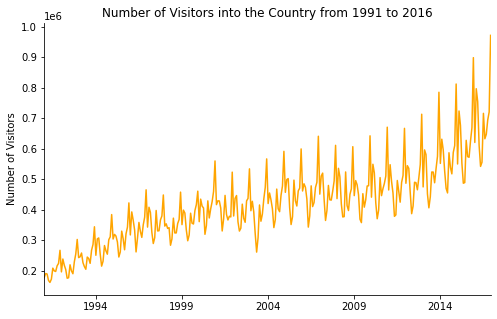

In [42]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color='orange')
ax.set_xlabel('')
ax.set_ylabel('Number of Visitors')
ax.set_title('Number of Visitors into the Country from 1991 to 2016')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

Therefore, it was apparent that the data seemed to follow some rough yearly seasonality. A consistent upward trend was also observed while variance appeared to increase towards 2016. To understand the variations further a timeseries decomposition can be viewed as below.

In [43]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# components = seasonal_decompose(df, model='additive')
# components.plot()

In [44]:
y.describe().round(4)

count       312.0000
mean     419407.3718
std      132443.0593
min      161400.0000
25%      332625.0000
50%      412950.0000
75%      488775.0000
max      971800.0000
Name: Number of Visitors, dtype: float64

Moreover, the mean entrance of visitors is 419307 across the entire timeframe (1991-2016). Also the highest recorded number was 971800 while the lowest was 161400.

### Multiplicative Holt-Winters Exponential Smoothing

#### Rationale

The Holt-Winters exponential smoothing model considers trend and seasonal correctional methods. Therefore, the following model was selected on the rationale of seasonality and trend variations being key patterns in the data, as observed in the EDA.

Also it is known that the additive model is most appropriate for data that has seasonal variations that are roughly constant across the provided period, while a multiplicative one suits data when the seasonal variation is proportional to the trend. Since the EDA showed that the variance of seasonal periods increased towards 2016 it made sense to proceed with a model formulation that applied the multiplicative method. 

#### Methodology

The selected model compromises of three different components, these being the level, trend and seasonal indices. (use equations below this line) Thus, predictions of the future or of current instances are computed on the basis of these three influences.  

Using exponential smoothing across these different aspects that the model considers, it determines a weight for past observations. This means that the model gives greater weight to observations recorded more recent, than those recorded before them. Hence, parameters alpha, beta and delta influence the level of exponential smoothing applied to level, trend and seasonal components respetively. These values are optimised using least squares. (put argmin equation below)

Before deriving any forecasts, diagnostics were performed to ensure that the model was appropriate in forecasting of the provided data. 

#### Diagnostics

In [45]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.310 (0.078)
 beta  (trend)    0.012 (0.008)
 delta (seasonal) 0.362 (0.050)
 
 In-sample fit:
 MSE               434674551.141
 RMSE              20848.850
 Log-likelihood   -3545.566
 AIC               7099.131
 BIC               7114.103


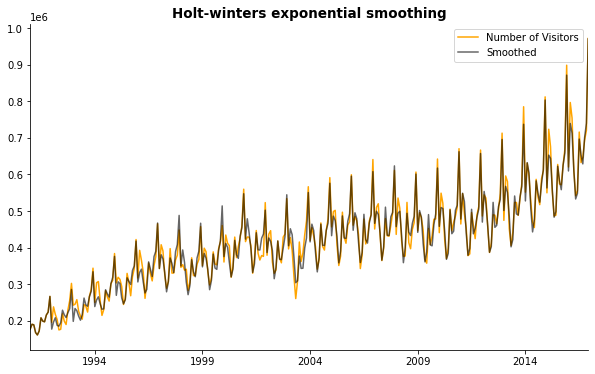

In [46]:
smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='orange', label='Number of Visitors')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

Holt-Winters exponential smoothing curve following very closely with the data was a good indication of model use for the given data. 

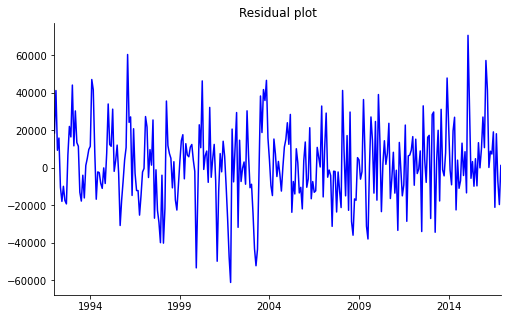

In [47]:
resid = (y-mhw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

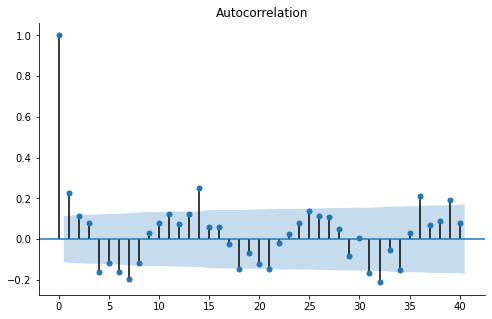

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

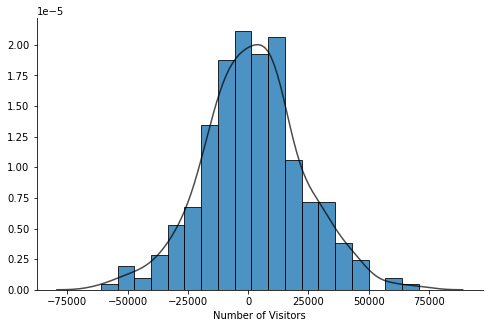

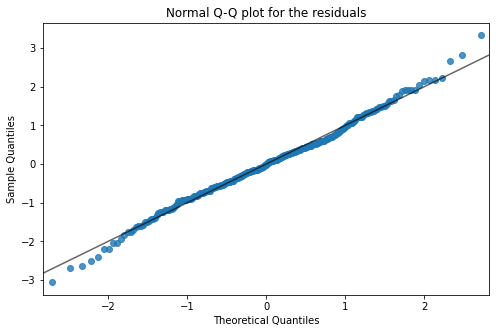

In [49]:
histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

The residuals appeared not to follow any particular pattern, however, a qqplot of them showed some slight deviation from the line, through which did raise some concern for normality. Moreover, the autocorrelations did not give any unusual results and were reasonable. Thus, provided these diagnostics, other than the slight concern for normality, the model was confirmed appropriate for the data.   

#### Model Validation

In [50]:
# Real time forecasting 


validation=y['2008-01':].index
start = y.index.get_loc('2008-01') 

pred = []
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred.append(model.forecast(1)[0]) # multiplicate holt winters forecast

columns=['Holt-Winters Multiplicative', 'Actual']
results = np.vstack([pred, actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [52]:
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)
#23645.48	2140.26

RMSE       SE
Holt-Winters Multiplicative  23645.48  2140.26

Now, we were able to use the best derived model from above to determine the 24 month forecast for the number of visitors into the country.

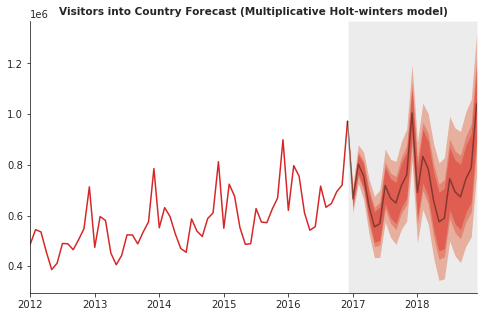

In [53]:
h=24

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred=pd.Series(mhw.forecast(h), index=test)
var = mhw.forecastvariance(h)
# pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(mhw.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(mhw.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(mhw.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Visitors into Country Forecast (Multiplicative Holt-winters model)', fontsize=10.5, fontweight='bold')
sns.despine()
plt.show()

### Multiplicative Holt-Winters Exponential Smoothing with Dampening

#### Rationale

Since the multiplicative Holt-Winters Exponential Smoothing with Dampening model follows very similar principles to the previous model, the same rationale applies. However, the addition of dampening also allows us to address the potential issue of extrapolating the trend indefinitely into the future. Therefore, producing such a model should be able to prevent the resulting of implausible forecasts.

#### Methodology

The model follows the same principles and components of the previous one, but with the inclusion of a dampening parameter (phi). Effectively , this applies an additional weight to both the seasonality and trend components. (Show new equations below).

#### Diagnostics

In [54]:
mhw=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.482 (0.077)
 beta  (trend)    0.000 (0.029)
 delta (seasonal) 0.412 (0.086)
 phi (damping)    0.792 (0.054)
 
 In-sample fit:
 MSE               445818496.985
 RMSE              21114.414
 Log-likelihood   -3549.515
 AIC               7109.029
 BIC               7127.744


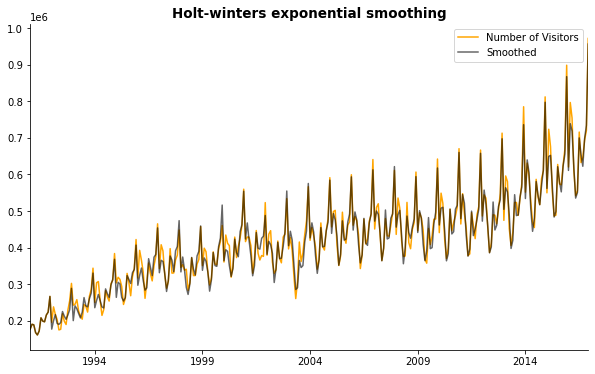

In [55]:
smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='orange', label='Number of Visitors')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

Holt-Winters exponential smoothing curve with dampening following very closely with the data was a good indication of model use for the given data. 

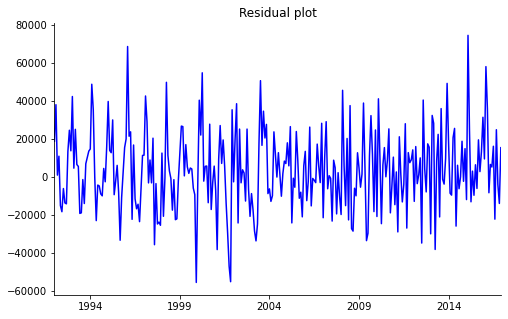

In [56]:
resid = (y-mhw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

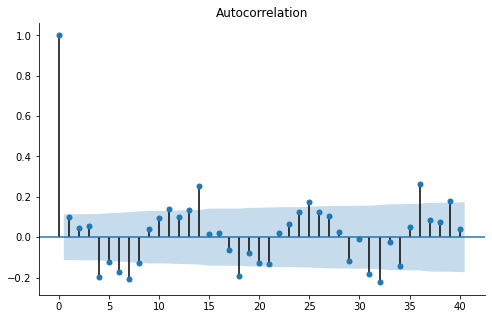

In [57]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

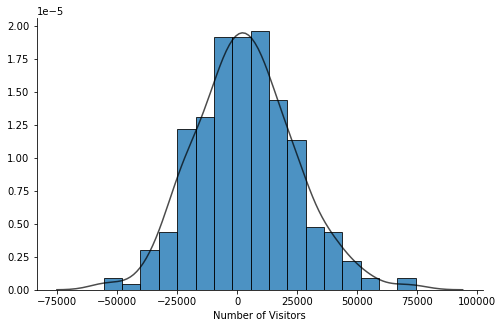

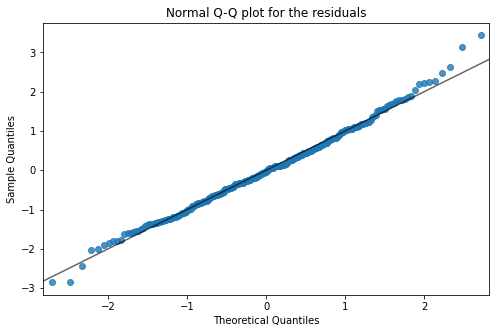

In [58]:
histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

Similarly, to the previous model the residuals did not follow any patterns, while normality was also questionable but relatively reasonable with the slight deviations from the line at the extremities. Moreover, the autocorrelations were also not an issue with these not containing any high values.

### Model Validation and Selection

In [66]:
# Real time forecasting 


validation=y['2008-01':].index
start = y.index.get_loc('2008-01') 

pred = []
pred1 = []
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=True, m=12)
    model.fit()
    pred1.append(model.forecast(1)[0]) # multiplicate holt winters forecast with dampening

columns=['Holt-Winters Multiplicative', 'Holt-Winters Multiplicative (with dampening)', 'Actual']
results = np.vstack([pred, pred1, actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [68]:
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

RMSE       SE
Holt-Winters Multiplicative                   23645.48  2140.26
Holt-Winters Multiplicative (with dampening)  24164.86  2170.61

Now, we were able to use the models from above to determine the 24 month forecast for the number of visitors into the country.

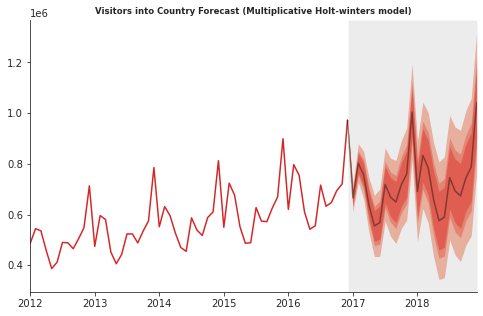

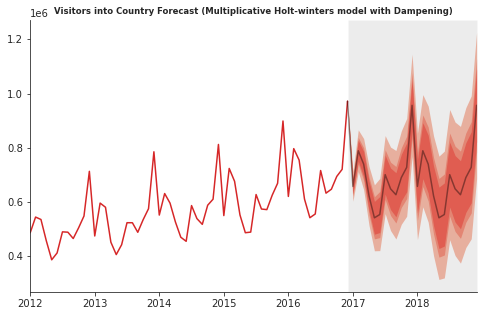

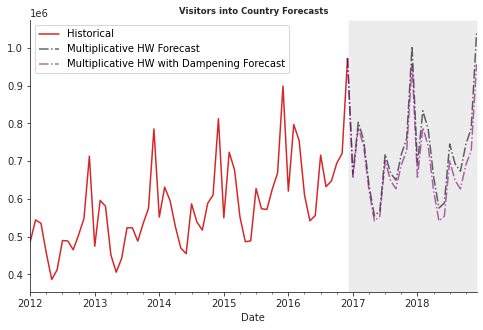

In [95]:
h=24

mhw1=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw1.fit()

mhw2=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhw2.fit()

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred1=pd.Series(mhw1.forecast(h), index=test)
# pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(mhw1.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(mhw1.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(mhw1.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred1, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Visitors into Country Forecast (Multiplicative Holt-winters model)', fontsize=8.5, fontweight='bold')
sns.despine()
plt.show()

pred2=pd.Series(mhw.forecast(h), index=test)
# pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(mhw2.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(mhw2.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(mhw2.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred2, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Visitors into Country Forecast (Multiplicative Holt-winters model with Dampening)', fontsize=8.5, fontweight='bold')
sns.despine()
plt.show()

last = y['01-2012':].iloc[-1:]

extended = last.append(pred1)
extended1 = last.append(pred2)

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8,5))
    y['01-2012':].plot(color='#D62728', label='Historical')
    extended.plot(color='black', linestyle='-.', alpha=0.6, label='Multiplicative HW Forecast')
    extended1.plot(color='purple', linestyle='-.', alpha=0.6, label='Multiplicative HW with Dampening Forecast')
    hold=ax.get_ylim()
    ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
    ax.set_ylim(hold)

plt.legend(loc='upper left')

plt.title('Visitors into Country Forecasts', fontsize=8.5, fontweight='bold')
sns.despine()
plt.show()

Given the results of the above models there was a slight difference in the RMSE and SE scores. The predictions were also slightly different, where the model with dampening had lower values compared to without dampening. While the differences in performance and forecassting were basically negligible the best model to consider would be the one with dampening. This was since the upward trend of the most recent observations shows the potential for continued increasing growth 

### Conclusion